## Glioma Enhancer selection

In [169]:
f = '/proj/DEV_ATAC/Build_20200903/Cerebellum/Cerebellum.loom'
fp = '/proj/DEV_ATAC/Build_20200903/All/All_peaks.loom'

with loompy.connect(f, 'r') as ds:
    with loompy.connect(fp, 'r') as dsp:
        print(ds.ca.keys())
        print(dsp.ca.keys())

['Age', 'All_fc_analysis_id', 'Analysis', 'Bplength', 'Cdnalibcomment', 'Cdnalibok', 'CellID', 'Cellconc', 'Chemistry', 'Clusterdensity', 'Clusterpf', 'Clusters', 'ClustersModularity', 'ClustersSurprise', 'Comment', 'DNase_sensitive_region_fragments', 'Datecaptured', 'Dateseqlib', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'Finalconc', 'Id', 'Idxset', 'Inputmrna', 'LSI_b', 'Label', 'Method', 'Molarity', 'NBins', 'Name', 'Neuronprop', 'Ngperulcdna', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersSurprise', 'PCA', 'Pcrcycles', 'Plugdate', 'Project', 'Read1specificseq', 'Roi', 'Sampleok', 'Seqcomment', 'Seqlibcomment', 'Seqlibok', 'Sex', 'Shearing', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSS_fragments', 'Targetnumcells', 'Tissue', 'Totcells', 'Totreads', 'Transcriptome', 'UMAP', 'UMAP3D', 'barcode', 'blacklist_region_fragments', 'cell_id', 'chimeric', 'duplicate', 'enhancer_region_fragments', 'is__cell_barcode', 'lowmapq', 'mitochondrial', 

In [8]:
#FeatureSelectionByMultilevelEnrichmentImports
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from collections import Counter
from tqdm import tqdm
import warnings

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot
from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel
from chromograph.pipeline import config

import cytograph as cg
from cytograph.plotting.colors import colorize
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species

import fisher

from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import loompy
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.spatial.distance import jaccard

config = config.load_config()

In [13]:
import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [176]:
from chromograph.pipeline.utils import *

f = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_peaks.loom'
f_agg = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_peaks.agg.loom'
binfile = '/proj/DEV_ATAC/Kriegstein_20200729/All/All.loom'
f_motif = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_motifs.loom'

## Plot markers

(19901, 14928)


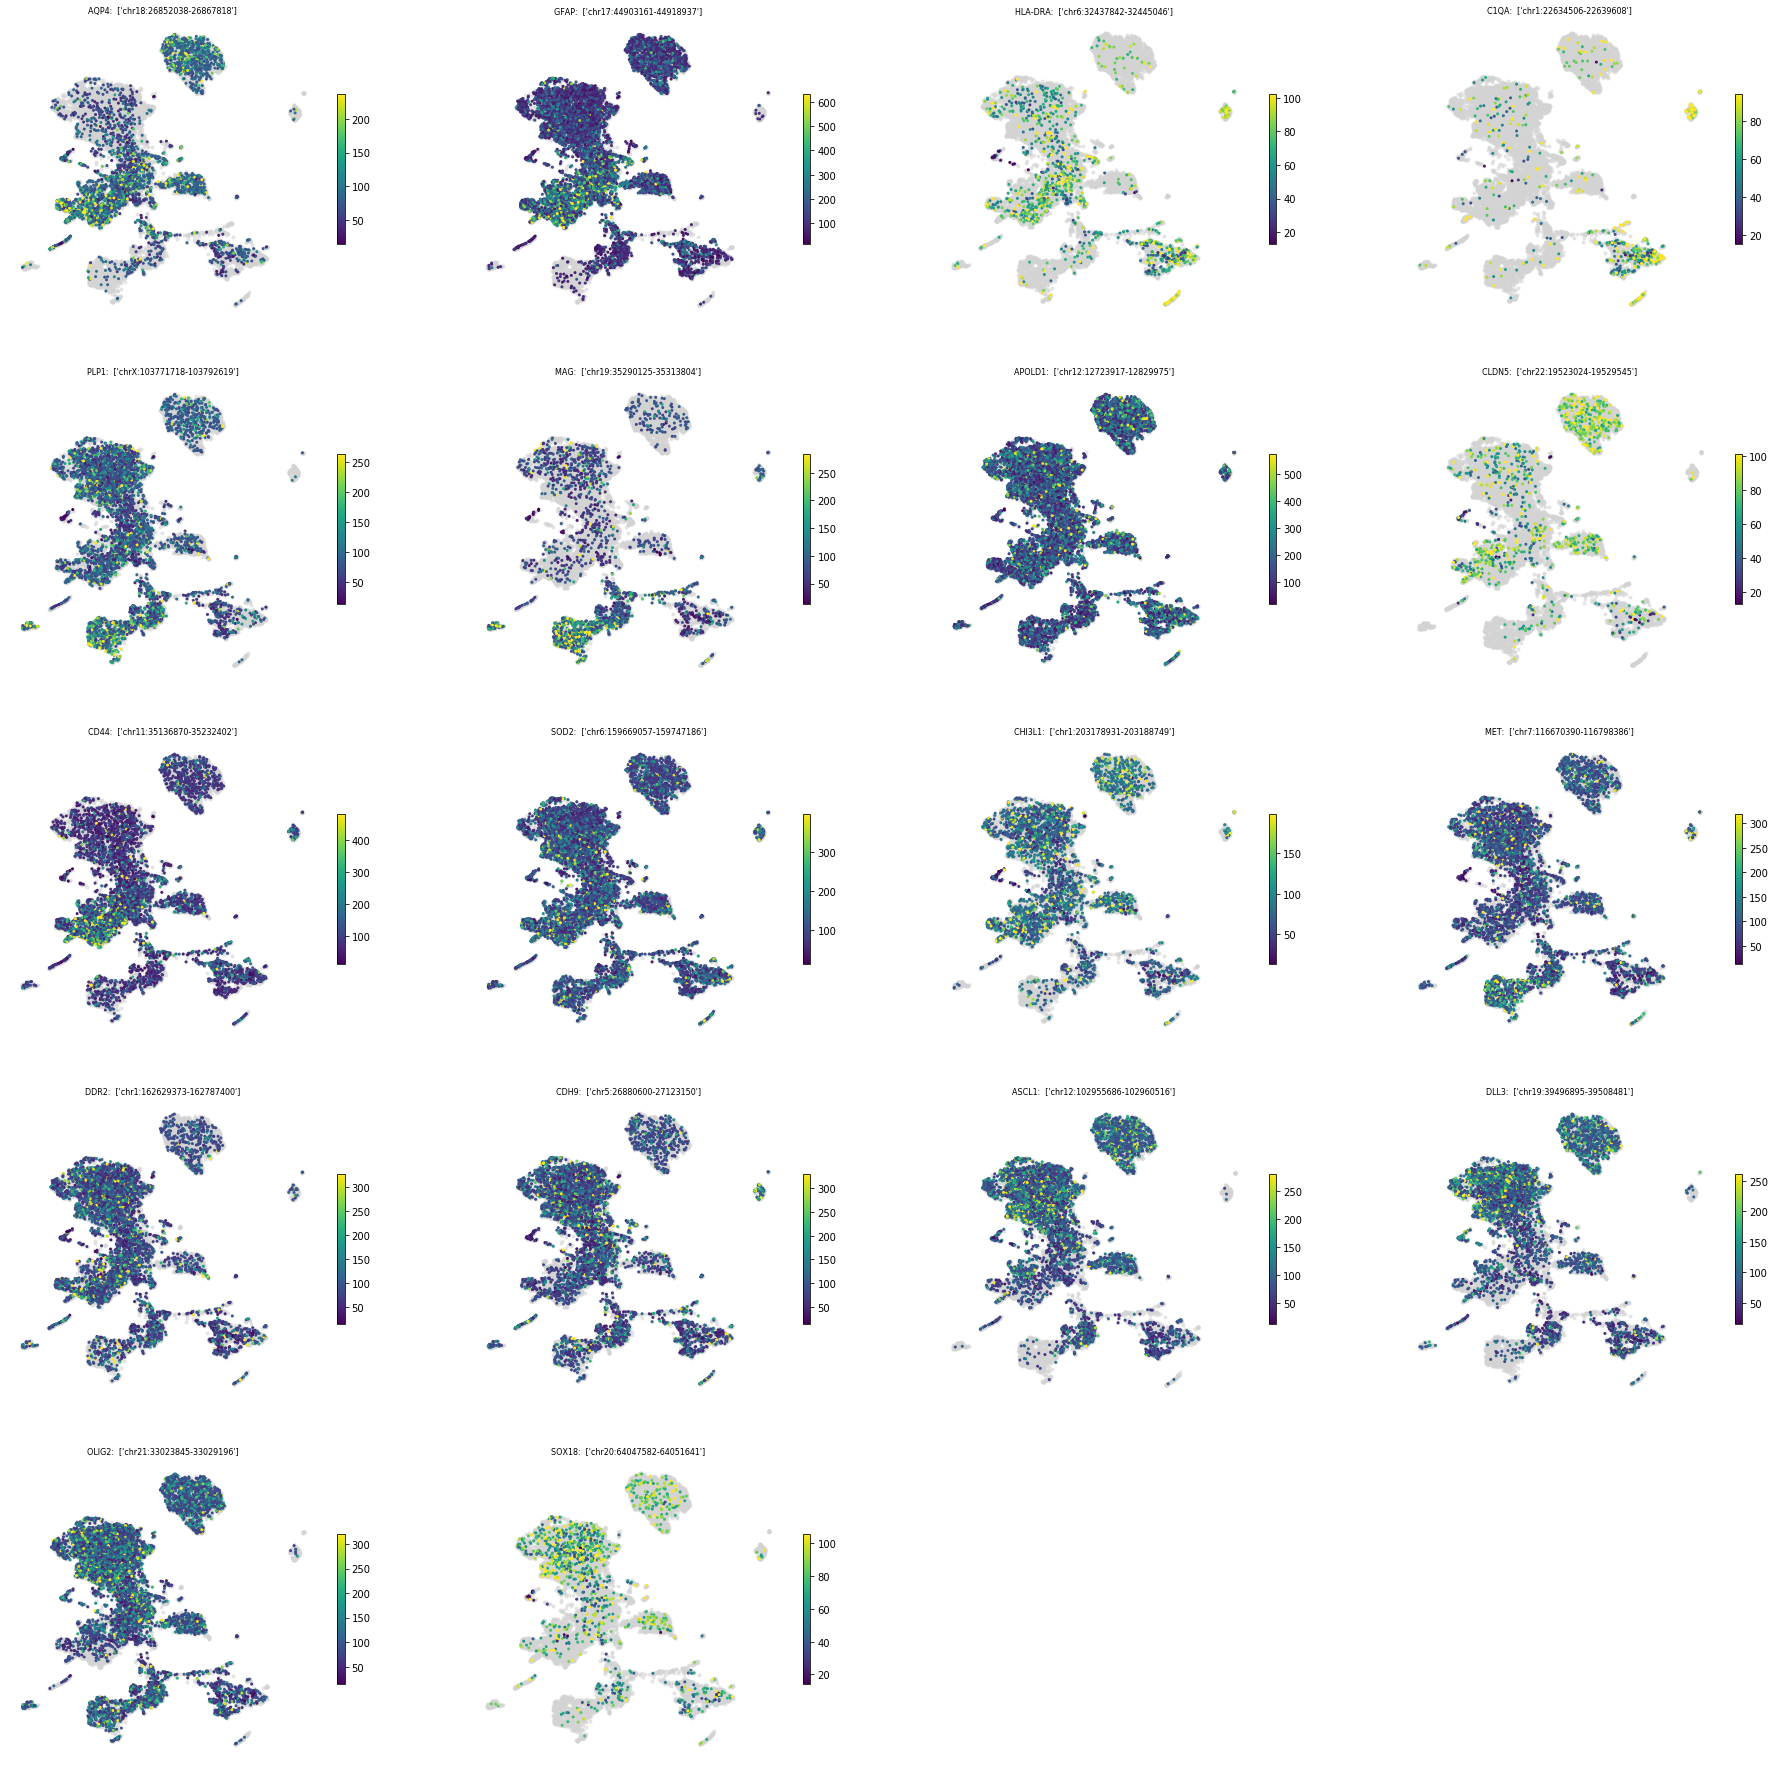

In [240]:
## Markers
markers = ['AQP4', 'GFAP', ## Astrocyte
           'HLA-DRA', 'C1QA', ## Myeloid
           'PLP1', 'MAG', ## Oligodendrocyte
           'APOLD1', 'CLDN5', ## Endothelial
           'CD44', 'SOD2', 'CHI3L1',  # Mesenchymal
           'MET', 'DDR2', 'CDH9', ## Classic
           'ASCL1', 'DLL3', 'OLIG2', ## Proneuronal
           'SOX18'  ## IDH-S
          ] 
out_file = '/home/camiel/misc/markers_Glioma.png'

f = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_GA.loom'
with loompy.connect(f, 'r') as ds:
    print(ds.shape)
    for marker in markers:
        if marker not in ds.ra.Gene:
            logging.info(f"Can't find {marker}")

with loompy.connect(f, 'r') as ds:
    marker_plot(ds, out_file, markers, lay='CPM', embedding='UMAP')

## Plot motifs

In [191]:

import matplotlib.pyplot as plt
import numpy as np
import loompy
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

def motif_plot(ds: loompy.LoomConnection, out_file: str, markers: list, embedding: str = "TSNE", layer: str = 'MZ') -> None:
    '''
    Generates a multi-panel plot to inspect Gene Accessibility Scores.
    
    Args:
        ds                    Connection to the .loom file to use
        markers               List of markers by Genesymbol to plot
        out_file              Name and location of the output file
        embedding             The embedding to use for UMI manifold plot (TSNE or UMAP)
        
    Remarks:
    
    '''
    
    n_cells = ds.shape[1]
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca["Clusters"]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
        
    # Compute a good size for the markers, based on local density
    min_pts = 50
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (1500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)
    
    nM = len(markers)
    
    fig = plt.figure(figsize=(20, np.ceil(nM/5)*4))
    
    i = 1
    for m in markers:
        ax = fig.add_subplot(np.ceil(nM/5), 5, i)
        
        # Draw edges
        if has_edges:
            lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
            ax.add_collection(lc)

        ## motif score    
        v = ds[layer][ds.ra['Gene'] == m, :][0]
        
        if layer == 'MZ':
            im = ax.scatter(pos[:,0], pos[:,1], cmap='coolwarm', c=v, vmin = -3, vmax = 3, 
                            marker='.', lw=0, s=epsilon)
        else:
            im = ax.scatter(pos[:,0], pos[:,1], cmap='coolwarm', c=v, vmin = np.quantile(v,.05) , vmax = np.quantile(v,.95), 
                            marker='.', lw=0, s=epsilon)

        fig.colorbar(im, ax=ax, orientation='vertical', shrink=.5)

        ax.set_title(f'{m} with {ds.ra["Total_peaks"][ds.ra["Gene"]==m][0]} peaks')
        ax.axis("off")
        
        i += 1
    
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')
    


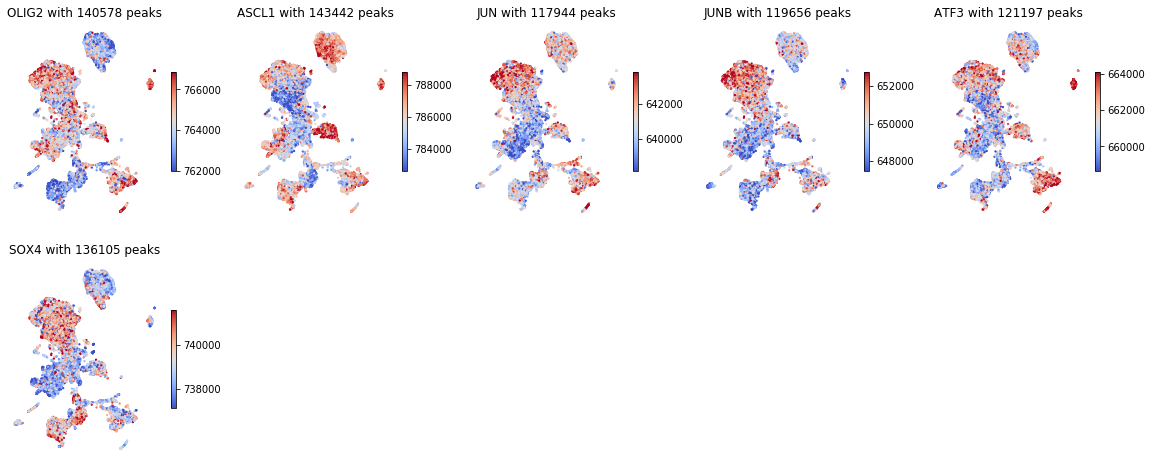

In [192]:
# from chromograph.plotting.motif_plot import motif_plot

markers = ['OLIG2', 'ASCL1', 'JUN', 'JUNB', 'ATF3', 
           'SOX4',]

with loompy.connect(f_motif, 'r') as ds:
    for marker in markers:
        if marker not in ds.ra.Gene:
            logging.info(f"Can't find {marker}")

with loompy.connect(f_motif, 'r') as ds:
    motif_plot(ds, '/home/camiel/misc/tumor_motifs.png', markers, 'UMAP', layer='smooth')

## Overlay with conservation scores

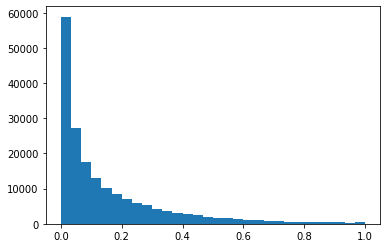

In [220]:
def get_conservation_score(ds):
    '''
    Overlays peaks of PeakxCell matrix with phastcon100way reference to estimate estimate evolutionaryconservation.
    
    Args:
        ds        LoomConnection with 'ID', 'Chr', 'Start' and 'End' row attributes
        
    Returns
        out       np.array or shape ds.shape[1] containing conservation scores
    '''
    BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in range(ds.shape[0])]).saveas('input.bed')
    subprocess.call(['/home/camiel/anaconda3/envs/chromo/bin/bigWigAverageOverBed', '/data/proj/scATAC/ref/hg38.phastCons100way.bw', 'input.bed', 'out.tab'])
    tab = np.loadtxt('out.tab', dtype=str, delimiter='\t')

    ## Cleanup
    subprocess.call(['rm', 'input.bed', 'out.tab'])

    return np.array(tab[:,-1].astype('float'))

f_agg = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_peaks.agg.loom'
with loompy.connect(f_agg, 'r+') as dsagg:    
    dsagg.ra.ConservationScore = get_conservation_score(dsagg)
    
    plt.hist(dsagg.ra.ConservationScore, bins=30)

In [221]:
def trim_by_conservation(enhancers: BedTool, s:int=300, max_plots = 0):
    trimmed = []
    plot = 0
    
    for enhancer in enhancers:
        enhancer_bed = f'{enhancer[3]}.bed'
        out_tab = f'{enhancer[3]}.tab'
        bases = BedTool([(enhancer[0], x, x+1, x) for x in range(int(enhancer[1])-1, int(enhancer[2]))]).saveas(enhancer_bed)
        subprocess.call(['/home/camiel/anaconda3/envs/chromo/bin/bigWigAverageOverBed', '/data/proj/scATAC/ref/hg38.phastCons100way.bw', enhancer_bed, out_tab])
        tab = np.loadtxt(out_tab, dtype=str, delimiter='\t')
        con = tab[:,-1].astype(float)
        
        n_windows = len(con) - s
        
        if n_windows >= 1:
            score = [np.sum(con[x:x+s])for x in range(n_windows)]
            sel = np.where(score == np.max(score))[0][0]
            
            if plot < max_plots:
                # plot figure
                fig, ax = plt.subplots(2,1)
                ax[0].plot(con)
                ax[0].axvline(sel, c='red')
                ax[0].axvline(sel+s, c='red')
                ax[1].plot(np.linspace(np.round(s/2), n_windows+np.round(s/2), n_windows), score)
                ax[1].set_xlim(0,len(con))
                plot += 1
            
            ch, st, en = enhancer[0], int(enhancer[1])+sel, int(enhancer[1])+sel+s
            trimmed.append([ch, st, en, f'{ch}:{st}-{en}'])
        else:
            trimmed.append([enhancer[x] for x in range(4)])

        subprocess.call(['rm', enhancer_bed, out_tab])
        
    return BedTool([[x[0], str(x[1]),str(x[2]), x[3]] for x in trimmed])

## Selecting positive peaks in PNs, MES, INM and 'All tumor'

In [174]:
## Selecc clusters
MES = [18, 19, 20]
INM = [14, 16, 17]
PN = [21]
IDH = [9, 10, 11, 12, 13]

GLIOMA = np.sort(np.hstack([PN, MES, INM, IDH]))

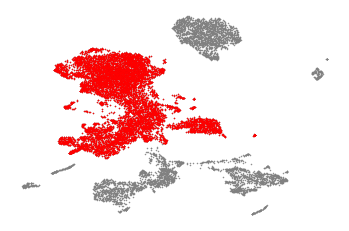

In [177]:
f = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_peaks.loom'
with loompy.connect(f, 'r') as ds:
    v = np.array([x in GLIOMA for x in ds.ca.Clusters])
    plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], s=1, c='gray', marker='.')
    plt.scatter(ds.ca.UMAP[v,0], ds.ca.UMAP[v,1], s=1, c='red', marker='.')
    plt.axis("off")
    plt.savefig(f'/home/camiel/misc/Glioma_UMAP.png')

In [178]:
GLIOMA

array([ 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21])

In [223]:
def remove_elements(ds, reference):
    '''
    '''
    peak_list = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in range(len(ds.ra['Chr']))]).saveas()
    for x in ['promoter', 'ctcf', 'blacklist']:
        sub = BedTool(os.path.join(reference, 'regions', f'{x}.bed'))
        peak_list = peak_list.subtract(sub, A=True)
    enh_peaks = [x[3] for x in peak_list]
    Valid = [x in enh_peaks for x in ds.ra.ID]
    
    return np.array(Valid)

def jaccard_heatmap(x, labels):
    '''
    '''
    m = np.zeros((len(x),len(x)))
    for i in range(len(x)):
        for j in range(i, len(x)):
            m[i,j] = jaccard(x[i], x[j])
            m[j,i] = m[i,j]
        m[i,i] = 1
    m = 1 - m
    
    fig, ax = plt.subplots(1,1)
    im = ax.imshow(m)
    im = ax.imshow(m, extent=[-1,1,-1,1])
    Irange = np.linspace(-1+(1/len(labels)),1-(1/len(labels)),len(labels))
    Jrange = np.linspace(1-(1/len(labels)),-1+(1/len(labels)),len(labels))
    ax.set_xticks(Irange)
    ax.set_yticks(Jrange)
    ax.set_xticklabels(labels, rotation=45, rotation_mode="anchor", ha="right")
    ax.set_yticklabels(labels)
    
    # Loop over data dimensions and create text annotations.
    for i in range(len(x)):
        for j in range(len(x)):
            text = ax.text(Irange[i], Jrange[j], np.round(m[i, j],3),
                           ha="center", va="center", color="w", weight = 'bold')

## Annotated enhancers only

In [224]:
def isolate_enhancers(ds, reference):
    '''
    '''
    peak_list = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in range(len(ds.ra['Chr']))]).saveas()
    enhancers = BedTool(reference)
    peak_list = peak_list.intersect(enhancers, wa=True)
    enh_peaks = set([x[3] for x in peak_list])
    Valid = [x in enh_peaks for x in ds.ra.ID]
    
    return np.array(Valid)

12:04:09 INFO     [21] valid: 20558
12:04:09 INFO     [18, 19, 20] valid: 13472
12:04:09 INFO     [14, 16, 17] valid: 15043
12:04:09 INFO     [9, 10, 11, 12, 13] valid: 11296
12:04:09 INFO     [ 9 10 11 12 13 14 16 17 18 19 20 21] valid: 8979
12:04:30 INFO     5511 enhancers after filtering potential cross activation
12:04:45 INFO     3165 enhancers after filtering potential cross activation
12:05:01 INFO     3473 enhancers after filtering potential cross activation
12:05:13 INFO     2431 enhancers after filtering potential cross activation
12:05:22 INFO     1442 enhancers after filtering potential cross activation


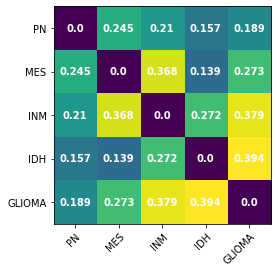

In [226]:
with loompy.connect(f_agg, 'r') as dsagg:
    selection = isolate_enhancers(dsagg, os.path.join(config.paths.ref, 'regions', f'enhancer.bed'))
    selection = (selection) & (dsagg.ra.Chr != 'chrY') ## Remove the Y chromosome
    
    threshold = 5
    Valids_enh = []
    d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
    binary = dsagg['CPM'][:,:]/(d/1000).reshape((d.shape[0],1)) > threshold
    for population in [PN, MES, INM, IDH, GLIOMA]:
        mu = np.mean(binary[:,population], axis=1)
        Valids_enh.append(np.logical_and(selection, mu > 0.8))
        logging.info(f'{population} valid: {np.sum(Valids_enh[-1])}')

    ## Remove elements overlapping with the Lake (adult brain) and Greenleaf (hematopoiesis) datasets
    candidates_enh = []
    for v in Valids_enh:
        subset = BedTool([(dsagg.ra['Chr'][x], str(dsagg.ra['Start'][x]), str(dsagg.ra['End'][x]), str(dsagg.ra['ID'][x])) for x in np.where(v)[0]]).saveas()
        for f in ['/fish/other_tmp/camiel_tmp/Lake/active_elements.hg38.bed', 
                  '/fish/other_tmp/camiel_tmp/Greenleaf/active_elements.hg38.bed']:
            control = BedTool(f)
            subset = subset.subtract(control, A=True)
        peaks = [x[3] for x in subset]
        candidates_enh.append(np.array([x in peaks for x in dsagg.ra.ID]))
        logging.info(f'{len(peaks)} enhancers after filtering potential cross activation')        
        
jaccard_heatmap(candidates_enh, labels = ['PN', 'MES', 'INM', 'IDH', 'GLIOMA'])
plt.savefig('/home/camiel/misc/enhancers_jaccard_annotated.png')

12:05:22 INFO     Selected 100 out of 5511 valids
12:05:22 INFO     Selected 100 out of 3165 valids
12:05:23 INFO     Selected 100 out of 3473 valids
12:05:23 INFO     Selected 100 out of 2431 valids
12:05:23 INFO     Selected 100 out of 1442 valids
12:05:23 INFO     Selected 100 out of 5511 valids
12:05:24 INFO     Selected 100 out of 3165 valids
12:05:24 INFO     Selected 100 out of 3473 valids
12:05:24 INFO     Selected 100 out of 2431 valids
12:05:25 INFO     Selected 100 out of 1442 valids


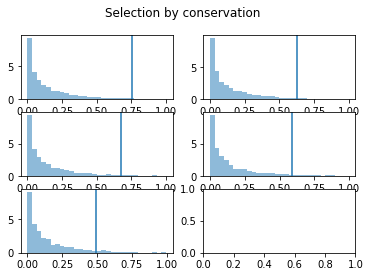

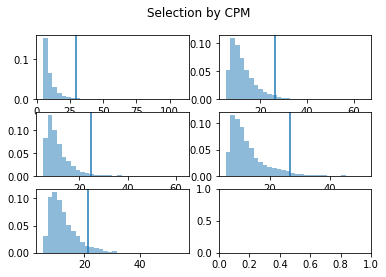

In [227]:
N_candidates = 100

with loompy.connect(f_agg, 'r') as dsagg:
    enh_by_cons = []
    
    fig, ax = plt.subplots(3,2)
    ax = ax.flatten()
    for i, x in enumerate(candidates_enh):
        q = np.quantile(dsagg.ra.ConservationScore[x], 1-(N_candidates/np.sum(x)))
        enh_by_cons.append((x) & (dsagg.ra.ConservationScore > q))
        
        ## Plot
        ax[i].hist(dsagg.ra.ConservationScore[x], bins = 30, density=True, alpha=.5)
        ax[i].axvline(q)
        logging.info(f'Selected {np.sum(enh_by_cons[-1])} out of {np.sum(x)} valids')
    fig.suptitle('Selection by conservation')

        
with loompy.connect(f_agg, 'r') as dsagg:
    enh_by_CPM = []
    
    fig, ax = plt.subplots(3,2)
    ax = ax.flatten()
    for i, (population, x) in enumerate(zip([PN, MES, INM, IDH, GLIOMA], candidates_enh)):
        ## Get the means across clusters and normalize against peaksize
        mu = np.mean(dsagg['CPM'][:,population], axis=1)
        d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
        mu = mu/ (d/1000)
        
        q = np.quantile(mu[x], 1-(N_candidates/np.sum(x)))
        enh_by_CPM.append((x) & (mu > q))
        
        ## Plot
        ax[i].hist(mu[x], bins = 30, density=True, alpha=.5)
        ax[i].axvline(q)
        logging.info(f'Selected {np.sum(enh_by_CPM[-1])} out of {np.sum(x)} valids')
    fig.suptitle('Selection by CPM')


jaccard similarity with conservation: 0.10497237569060769 and by CPM: 0.12994350282485878
jaccard similarity with conservation: 0.1428571428571429 and by CPM: 0.11111111111111116
jaccard similarity with conservation: 0.10497237569060769 and by CPM: 0.13636363636363635
jaccard similarity with conservation: 0.11731843575418999 and by CPM: 0.14942528735632188
jaccard similarity with conservation: 0.19760479041916168 and by CPM: 0.22699386503067487


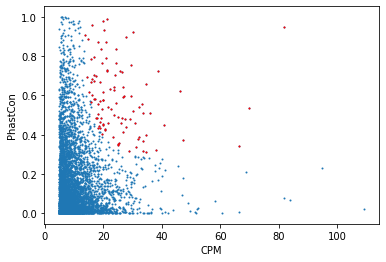

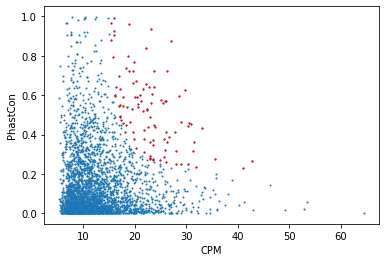

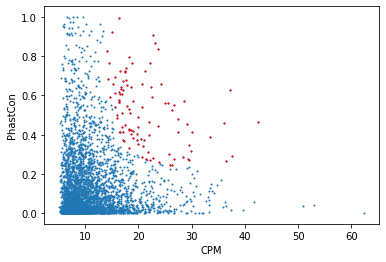

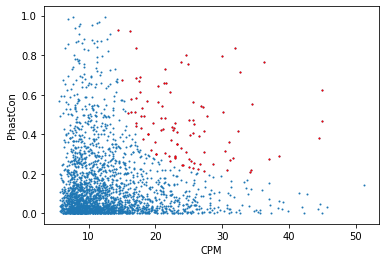

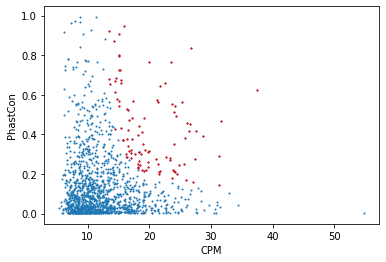

In [228]:
## Selection by ranked consensus
import scipy.stats as ss

N_candidates =100

with loompy.connect(f_agg, 'r') as dsagg:
    enh_by_consensus = []

    for i, (population, x) in enumerate(zip([PN, MES, INM, IDH, GLIOMA], candidates_enh)):
        IDs = dsagg.ra.ID[x]
        con = dsagg.ra.ConservationScore[x]
        
        ## Get the means across clusters and normalize against peaksize
        mu = np.mean(dsagg['CPM'][:,population], axis=1)
        d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
        mu = mu/ (d/1000)
        CPM = mu[x]
        
        ## Rank data by conservation score and CPM
        r1 = ss.rankdata(con)
        r2 = ss.rankdata(CPM)
        
        ## Multiply ranks
        rank = r1+r2
        q = np.quantile(rank, 1-(N_candidates/len(rank)))
        
        fig, ax = plt.subplots(1,1)
        ax.scatter(CPM, con, s=1)
        ax.scatter(CPM[rank >= q], con[rank >= q], s=1, c='red')
        ax.set_xlabel('CPM')
        ax.set_ylabel('PhastCon')

        v_IDs = IDs[rank >= q]
        enh_by_consensus.append([x in v_IDs for x in dsagg.ra.ID])
        
        print(f'jaccard similarity with conservation: {1-jaccard(enh_by_consensus[i], enh_by_cons[i])} and by CPM: {1-jaccard(enh_by_consensus[i], enh_by_CPM[i])}')

## Selecting unlabeled enhancers 

12:09:26 INFO     [21] valid: 31313
12:09:26 INFO     [18, 19, 20] valid: 20808
12:09:26 INFO     [14, 16, 17] valid: 22873
12:09:26 INFO     [9, 10, 11, 12, 13] valid: 16951
12:09:26 INFO     [ 9 10 11 12 13 14 16 17 18 19 20 21] valid: 12605
12:09:56 INFO     3767 enhancers after filtering potential cross activation
12:10:16 INFO     2594 enhancers after filtering potential cross activation
12:10:40 INFO     3297 enhancers after filtering potential cross activation
12:10:57 INFO     2342 enhancers after filtering potential cross activation
12:11:10 INFO     1126 enhancers after filtering potential cross activation


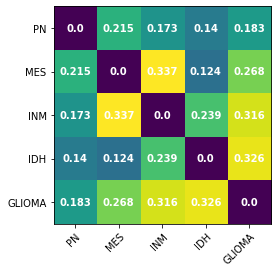

In [229]:
with loompy.connect(f_agg, 'r') as dsagg:    
    
    ## Remove some known elements that we aren't interested in
    selection = remove_elements(dsagg, config.paths.ref)
    selection = (selection) & (dsagg.ra.Chr != 'chrY') ## Remove the Y chromosome
    
    threshold = 5
    Valids = []
    mus = []
    d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
    binary = dsagg['CPM'][:,:]/(d/1000).reshape((d.shape[0],1)) > threshold
    
    for population in [PN, MES, INM, IDH, GLIOMA]:
        mu = np.mean(binary[:,population], axis=1)
        mus.append(mu)
        Valids.append(np.logical_and(selection, mu > 0.8))
        logging.info(f'{population} valid: {np.sum(Valids[-1])}')

    ## Remove elements overlapping with the Lake (adult brain) and Greenleaf (hematopoiesis) datasets
    candidates = []
    for i, v in enumerate(Valids):
        subset = BedTool([(dsagg.ra['Chr'][x], str(dsagg.ra['Start'][x]), str(dsagg.ra['End'][x]), str(dsagg.ra['ID'][x])) for x in np.where(v)[0]]).saveas()
        for f in ['/fish/other_tmp/camiel_tmp/Lake/active_elements.hg38.bed', 
                  '/fish/other_tmp/camiel_tmp/Greenleaf/active_elements.hg38.bed']:
            control = BedTool(f)
            subset = subset.subtract(control, A=True)
        peaks = [x[3] for x in subset]
        peak_bin = np.array([x in peaks for x in dsagg.ra.ID])
        peak_bin[np.where(np.array(candidates_enh[i]) == True)[0]] = False    ## Only select peaks not already annotated
        candidates.append(peak_bin)
        logging.info(f'{np.sum(peak_bin)} enhancers after filtering potential cross activation')
    
jaccard_heatmap(candidates, labels = ['PN', 'MES', 'INM', 'IDH', 'GLIOMA'])
plt.savefig('/home/camiel/misc/enhancers_jaccard_free.png')

12:11:11 INFO     Selected 100 out of 3767 valids
12:11:11 INFO     Selected 100 out of 2594 valids
12:11:11 INFO     Selected 100 out of 3297 valids
12:11:11 INFO     Selected 100 out of 2342 valids
12:11:11 INFO     Selected 100 out of 1126 valids
12:11:12 INFO     Selected 100 out of 3767 valids
12:11:12 INFO     Selected 100 out of 2594 valids
12:11:13 INFO     Selected 100 out of 3297 valids
12:11:13 INFO     Selected 100 out of 2342 valids
12:11:14 INFO     Selected 100 out of 1126 valids


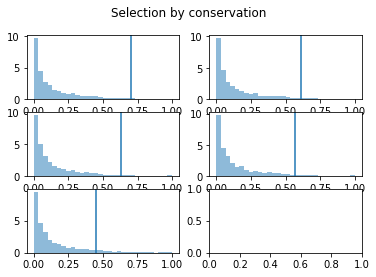

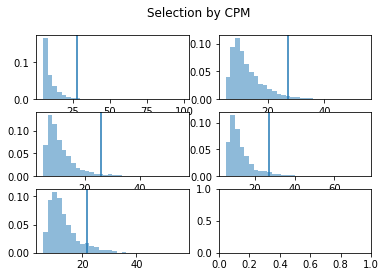

In [230]:
N_candidates = 100

with loompy.connect(f_agg, 'r') as dsagg:
    can_by_cons = []
    
    fig, ax = plt.subplots(3,2)
    ax = ax.flatten()
    for i, x in enumerate(candidates):
        q = np.quantile(dsagg.ra.ConservationScore[x], 1 - (N_candidates/np.sum(x)))
        can_by_cons.append((x) & (dsagg.ra.ConservationScore > q))
        
        ## Plot
        ax[i].hist(dsagg.ra.ConservationScore[x], bins = 30, density=True, alpha=.5)
        ax[i].axvline(q)
        logging.info(f'Selected {np.sum(can_by_cons[-1])} out of {np.sum(x)} valids')
    fig.suptitle('Selection by conservation')

with loompy.connect(f_agg, 'r') as dsagg:
    can_by_CPM = []
    
    fig, ax = plt.subplots(3,2)
    ax = ax.flatten()
    for i, (population, x) in enumerate(zip([PN, MES, INM, IDH, GLIOMA], candidates)):
        
        ## Get the means across clusters and normalize against peaksize
        mu = np.mean(dsagg['CPM'][:,population], axis=1)
        d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
        mu = mu/ (d/1000)
        
        q = np.quantile(mu[x], 1 - (N_candidates/np.sum(x)))
        can_by_CPM.append((x) & (mu > q))
        
        ## Plot
        ax[i].hist(mu[x], bins = 30, density=True, alpha=.5)
        ax[i].axvline(q)
        logging.info(f'Selected {np.sum(can_by_CPM[-1])} out of {np.sum(x)} valids')
    fig.suptitle('Selection by CPM')

jaccard similarity with conservation: 0.1235955056179775 and by CPM: 0.10497237569060769
jaccard similarity with all candidates: 0.026546323334218247
jaccard similarity with conservation: 0.1428571428571429 and by CPM: 0.14942528735632188
jaccard similarity with all candidates: 0.03855050115651504
jaccard similarity with conservation: 0.13636363636363635 and by CPM: 0.12994350282485878
jaccard similarity with all candidates: 0.030330603579011184
jaccard similarity with conservation: 0.16279069767441856 and by CPM: 0.1235955056179775
jaccard similarity with all candidates: 0.04269854824935948


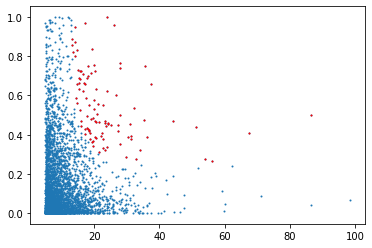

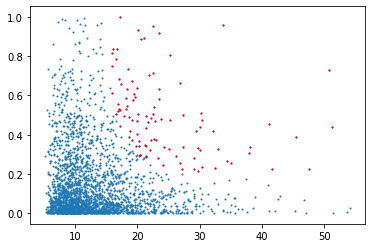

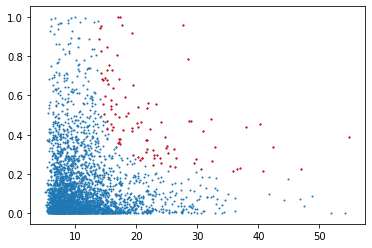

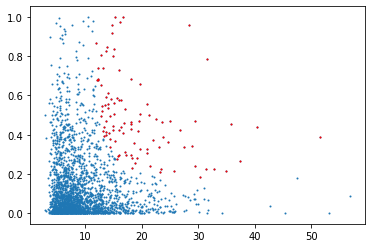

In [231]:
## Selection by ranked consensus
import scipy.stats as ss

N_candidates = 100

with loompy.connect(f_agg, 'r') as dsagg:
    can_by_consensus = []

    for i, (population, x) in enumerate(zip([PN, MES, INM, GLIOMA], candidates)):
        IDs = dsagg.ra.ID[x]
        con = dsagg.ra.ConservationScore[x]
        
        ## Get the means across clusters and normalize against peaksize
        mu = np.mean(dsagg['CPM'][:,population], axis=1)
        d = dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int') ## Get the peak sizes
        mu = mu/ (d/1000)
        CPM = mu[x]
        
        ## Rank data by conservation score and CPM
        r1 = ss.rankdata(con)
        r2 = ss.rankdata(CPM)
        
        ## Multiply ranks
        rank = r1*r2
        q = np.quantile(rank, 1-(N_candidates/len(rank)))
        
        fig, ax = plt.subplots(1,1)
        ax.scatter(CPM, con, s=1)
        ax.scatter(CPM[rank >= q], con[rank >= q], s=1, c='red')

        v_IDs = IDs[rank >= q]
        can_by_consensus.append([x in v_IDs for x in dsagg.ra.ID])
        
        print(f'jaccard similarity with conservation: {1-jaccard(can_by_consensus[i], can_by_cons[i])} and by CPM: {1-jaccard(can_by_consensus[i], can_by_CPM[i])}')
        print(f'jaccard similarity with all candidates: {1-jaccard(can_by_consensus[i], candidates[i])}')


## Metrics

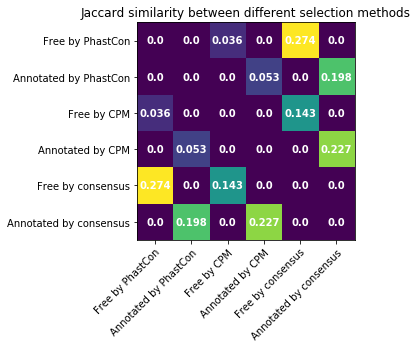

In [232]:
glioma_candidates = [can_by_cons[-1], enh_by_cons[-1], can_by_CPM[-1], enh_by_CPM[-1], can_by_consensus[-1], enh_by_consensus[-1]]
labels = ['Free by PhastCon', 'Annotated by PhastCon', 'Free by CPM', 'Annotated by CPM', 'Free by consensus', 'Annotated by consensus']

jaccard_heatmap(glioma_candidates, labels = labels)
plt.title(f'Jaccard similarity between different selection methods')
plt.savefig('/home/camiel/misc/enhancers_jaccard_methods.png')

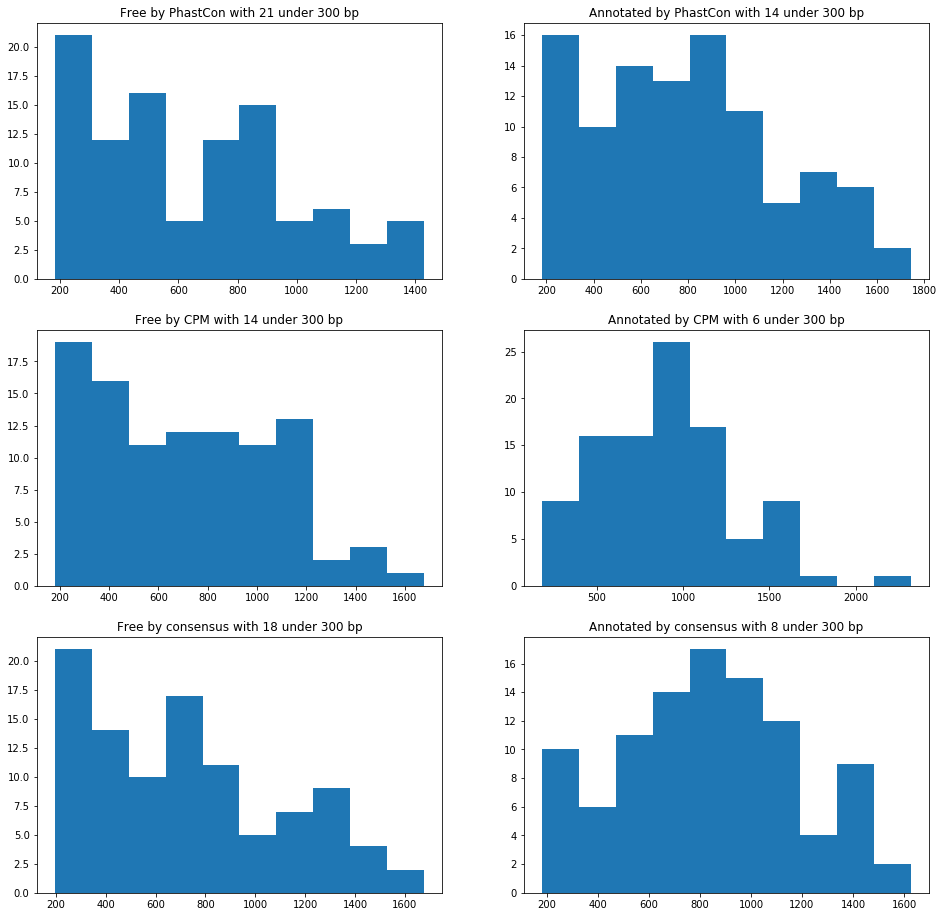

In [233]:
with loompy.connect(f_agg, 'r') as dsagg:
    fig, ax = plt.subplots(3,2, figsize=(16,16))
    ax = ax.flatten()
    
    for i, (x, y) in enumerate(zip(glioma_candidates, labels)):
        d = dsagg.ra.End[x].astype('int') - dsagg.ra.Start[x].astype('int')
        
        ax[i].hist(d)
        ax[i].set_title(f'{y} with {np.sum(d<300)} under 300 bp')
        
    plt.savefig('/home/camiel/misc/enhancers_length.png')

In [234]:
## Select final set
Selected_enhancers = np.array(can_by_consensus[-1]) | np.array(enh_by_consensus[-1])
np.sum(Selected_enhancers)

200

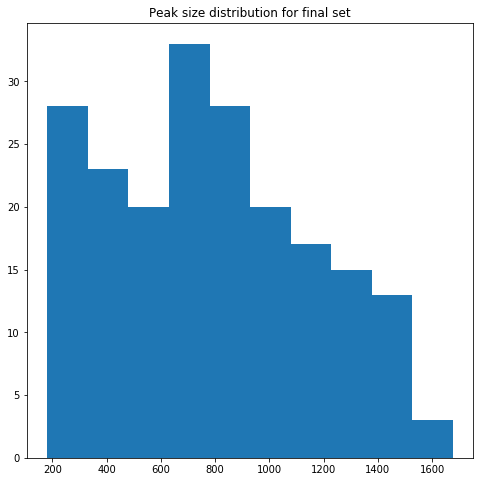

In [235]:
## Plot the fragment sizes

with loompy.connect(f_agg, 'r') as dsagg:
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    
    d = dsagg.ra.End[Selected_enhancers].astype('int') - dsagg.ra.Start[Selected_enhancers].astype('int')

    ax.hist(d)
    ax.set_title(f'Peak size distribution for final set')
        
    plt.savefig('/home/camiel/misc/enhancers_length.png')

12:25:28 INFO     Trimmed enhancers


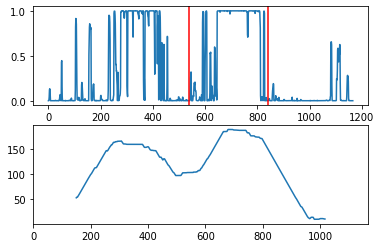

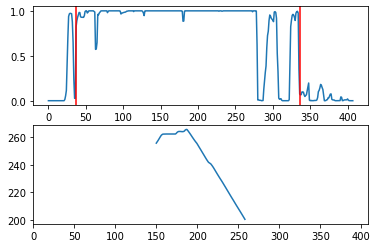

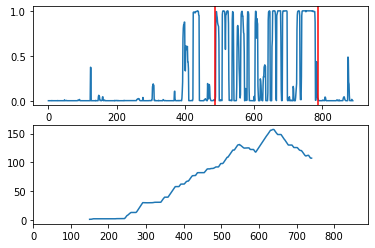

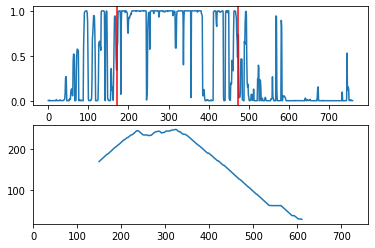

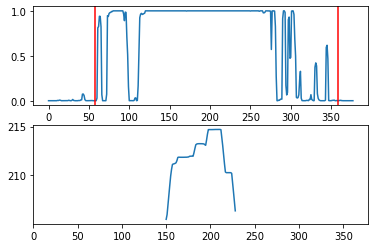

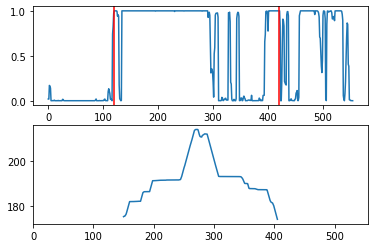

In [236]:
f_agg = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_peaks.agg.loom'

with loompy.connect(f_agg, 'r') as dsagg:
    enhancers = BedTool([(dsagg.ra.Chr[x], str(dsagg.ra.Start[x]), str(dsagg.ra.End[x]), dsagg.ra.ID[x]) for x in np.where(Selected_enhancers)[0]])
    trimmed_enhancers = trim_by_conservation(enhancers, max_plots=6).saveas('/data/proj/tumor/Kriegstein/outputs/enhancers_1.bed')
    logging.info(f'Trimmed enhancers')
    plt.savefig('/home/camiel/misc/enhancer_trimming.png')

In [238]:
## Get fasta files
fasta = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/fasta/genome.fa'
trimmed_enhcancers = trimmed_enhancers.sequence(fi=fasta)

sq = open(trimmed_enhancers.seqfn).read().split('\n')
sq = list(filter(None, sq))

table = np.array(sq).reshape(int(len(sq)/2),2)
np.savetxt('/data/proj/tumor/Kriegstein/outputs/enhancers_1.txt', table, fmt='%s', delimiter='\t')

In [162]:
for f in ['/fish/other_tmp/camiel_tmp/Lake/active_elements.hg38.bed', 
          '/fish/other_tmp/camiel_tmp/Greenleaf/active_elements.hg38.bed']:
    control = BedTool(f)
    print(control.count())

287233
483899


chr1	10782799	10783383	chr1:10782248-10783383	chr1	10782799	10783600	.	.	.
 chr1	10782249	10782400	chr1:10782248-10783383	chr1	10778000	10782400	.	.	.
 chr1	41455499	41456296	chr1:41455498-41456296	chr1	41453600	41456401	.	.	.
 chr1	44019515	44020199	chr1:44019362-44020227	chr1	44019515	44020199	.	.	.
 chr1	166950233	166950633	chr1:166950232-166950633	chr1	166949800	166953199	.	.	.
 chr1	175683800	175684000	chr1:175683719-175684114	chr1	175683800	175684000	.	.	.
 chr1	176989538	176989600	chr1:176989537-176990614	chr1	176989199	176989600	.	.	.
 chr1	176989800	176990200	chr1:176989537-176990614	chr1	176989800	176990200	.	.	.
 chr1	177208977	177209737	chr1:177208976-177209737	chr1	177208600	177210400	.	.	.
 chr1	208098905	208099159	chr1:208098904-208099159	chr1	208098200	208099400	.	.	.
 None


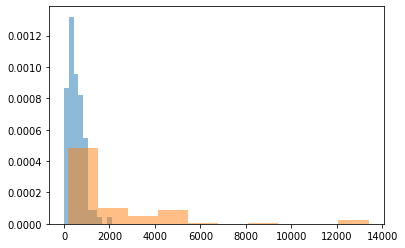

In [128]:
reference = os.path.join(config.paths.ref, 'regions', f'enhancer.bed')

with loompy.connect(f_agg, 'r') as dsagg:
    peak_list = BedTool([(dsagg.ra.Chr[x], str(dsagg.ra.Start[x]), str(dsagg.ra.End[x]), dsagg.ra.ID[x]) for x in np.where(enh_by_consensus[-1])[0]])
    enhancers = BedTool(reference)
    peak_list = peak_list.intersect(enhancers, wb=True)
    print(peak_list.head())
    peak_l = [int(x[2])-int(x[1]) for x in peak_list]
    enh_l = [int(x[6])-int(x[5]) for x in peak_list]
    plt.hist(peak_l, alpha=.5, density=True, bins=10)
    plt.hist(enh_l, alpha=.5, density=True, bins=10)
    
#     consensus = [min(int(x[2])-int(x[1]), int(x[6])-int(x[5])) for x in peak_list]
#     plt.hist(consensus, alpha=.5, density=True)
    plt.savefig('/home/camiel/misc/enhancer_peak_length.png')

chr1	19714	23399	.	.	.
 chr1	49800	70600	.	.	.
 chr1	71800	73000	.	.	.
 chr1	73200	73800	.	.	.
 chr1	78200	79400	.	.	.
 chr1	81000	83400	.	.	.
 chr1	83600	91599	.	.	.
 chr1	92000	92200	.	.	.
 chr1	101600	101800	.	.	.
 chr1	103601	105399	.	.	.
 None


(array([3.37923e+05, 4.48960e+04, 1.46800e+04, 4.64400e+03, 2.43700e+03,
        1.03100e+03, 5.66000e+02, 2.92000e+02, 1.93000e+02, 1.38000e+02,
        7.00000e+01, 4.90000e+01, 4.30000e+01, 2.50000e+01, 1.50000e+01,
        4.00000e+00, 6.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([2.00000e+00, 1.48860e+03, 2.97520e+03, 4.46180e+03, 5.94840e+03,
        7.43500e+03, 8.92160e+03, 1.04082e+04, 1.18948e+04, 1.33814e+04,
        1.48680e+04, 1.63546e+04, 1.78412e+04, 1.93278e+04, 2.08144e+04,
        2.23010e+04, 2.37876e+04, 2.52742e+04, 2.67608e+04, 2.82474e+04,
        2.97340e+04, 3.12206e+04, 3.27072e+04, 3.41938e+04, 3.56804e+04,
        3.71670e+04, 3.86536e+04, 4.01402e+04, 4.16268e+04, 4.31134e+04,
        4.46000e+04]),
 <a list of 30 Patch objects>)

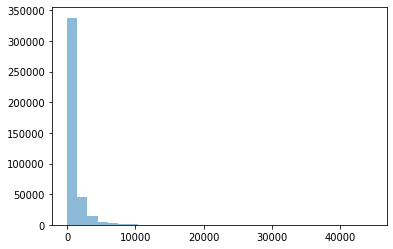

In [89]:
enhancers = BedTool(reference)
print(enhancers.head())
enh_l = [int(x[2])-int(x[1]) for x in enhancers]
plt.hist(enh_l, alpha=.5, bins=30)

## Glioma GAs

In [163]:
example = np.loadtxt('/fish/other_tmp/camiel_tmp/test_CONICS/OG_processed_data_portal.txt', dtype=str)

In [25]:
GA = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_GA.loom'
from collections import Counter

with loompy.connect(GA, 'r') as ds:
    logging.info(f'Loading data')
    cnt = Counter(ds.ra.Gene)
    invalid = [k for k, v in cnt.items() if v > 1]
    valid = [x not in invalid for x in ds.ra.Gene]
    vals = ds['smooth'][np.where(valid)[0],:]
#     vals = vals/(1e-6*ds.ca.GA_colsum)

    Logging.info(f'Adding rows and columns')
    export = np.hstack((np.zeros((np.sum(valid)+1,1)), np.vstack((np.zeros(ds.shape[1]), vals)))).astype(str)
    export[0,0] = 'GENE'
    export[0,1:] = ds.ca.CellID
    export[1:,0] = ds.ra.Gene[np.where(valid)[0]]
    
    Logging.info(f'Saving to file')
    np.savetxt('/fish/other_tmp/camiel_tmp/test_CONICS/Kriegstein_smooth.txt', export, delimiter='\t', fmt='%s')

In [33]:
GA = '/proj/DEV_ATAC/Kriegstein_20200729/IDH1/IDH1_GA.loom'
from collections import Counter

with loompy.connect(GA, 'r') as ds:
    logging.info(f'Loading data')
    cnt = Counter(ds.ra.Gene)
    invalid = [k for k, v in cnt.items() if v > 1]
    valid = [x not in invalid for x in ds.ra.Gene]
    vals = ds['CPM'][np.where(valid)[0],:]
#     vals = vals/(1e-6*ds.ca.GA_colsum)

    logging.info(f'Adding rows and columns')
    export = np.hstack((np.zeros((np.sum(valid)+1,1)), np.vstack((np.zeros(ds.shape[1]), vals)))).astype(str)
    export[0,0] = 'GENE'
    export[0,1:] = ds.ca.CellID
    export[1:,0] = ds.ra.Gene[np.where(valid)[0]]
    
    logging.info(f'Saving to file')
    np.savetxt('/fish/other_tmp/camiel_tmp/test_CONICS/IDH1_CPM.txt', export, delimiter='\t', fmt='%s')

15:41:34 INFO     Loading data
15:42:01 INFO     Adding rows and columns
15:43:36 INFO     Saving to file


(19901, 8619)


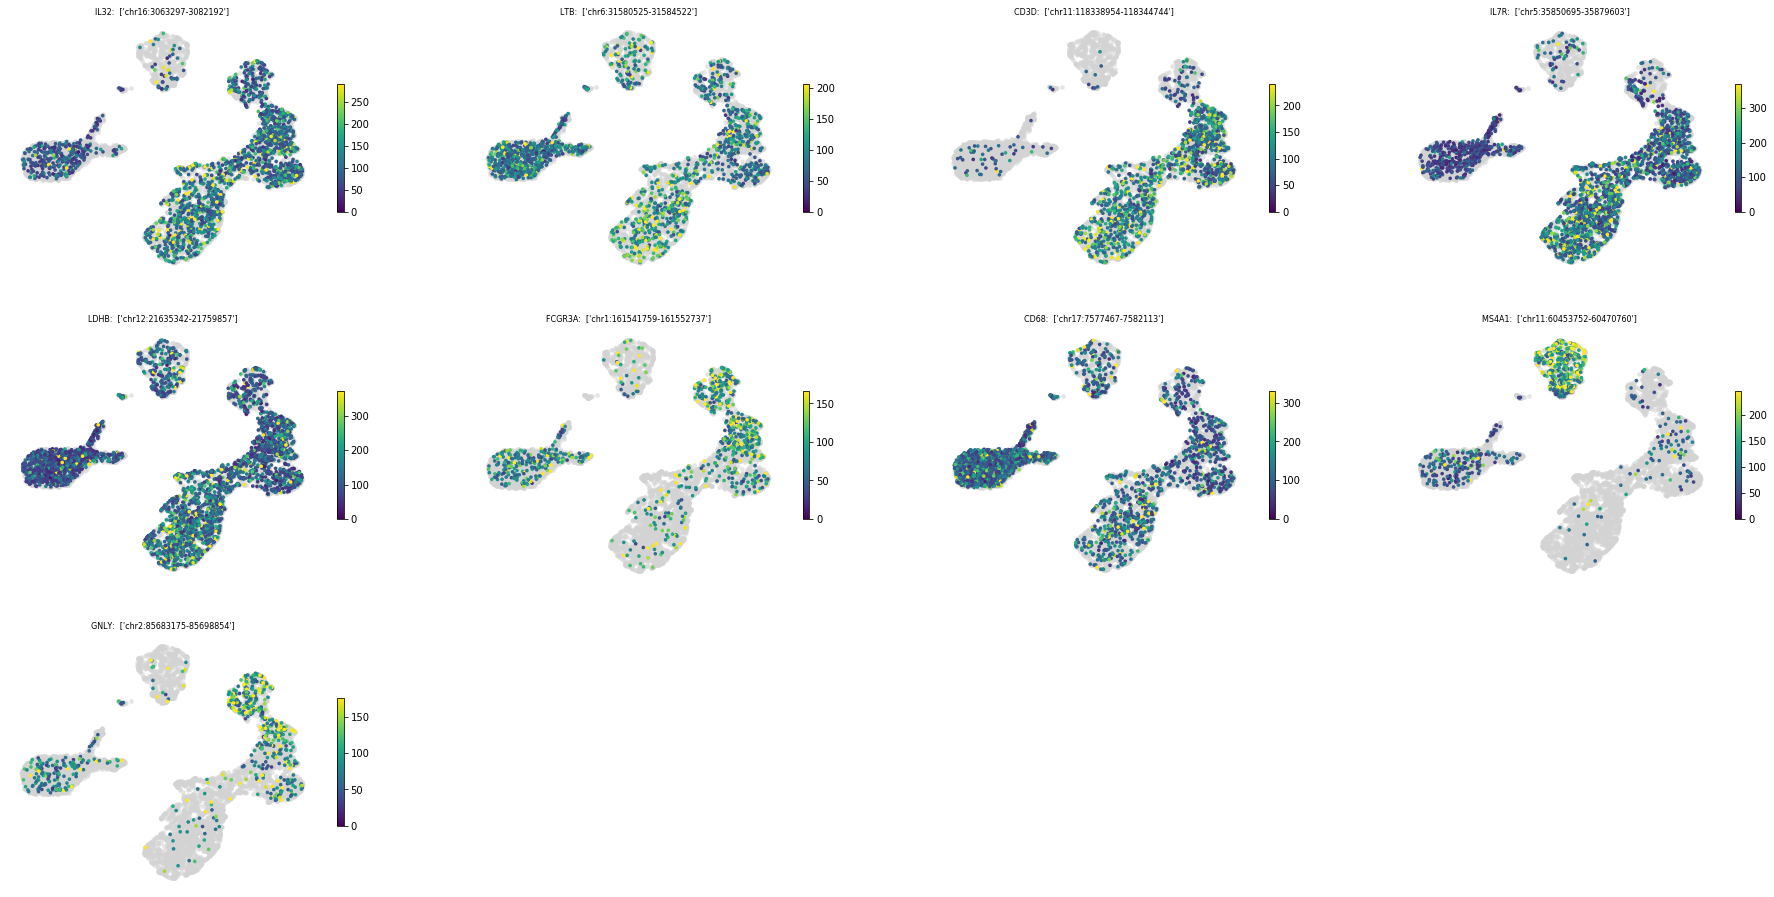

In [3]:
## Markers
markers = ['IL32', 'LTB', 'CD3D',
           'IL7R', 'LDHB', 'FCGR3A',
           'CD68', 'MS4A1', 'GNLY'
          ] 
out_file = '/home/camiel/misc/markers_PBMC.png'

f = '/proj/DEV_ATAC/PBMC_20200825/All/All_GA.loom'
with loompy.connect(f, 'r') as ds:
    print(ds.shape)
    for marker in markers:
        if marker not in ds.ra.Gene:
            logging.info(f"Can't find {marker}")

with loompy.connect(f, 'r') as ds:
    marker_plot(ds, out_file, markers, lay='CPM', embedding='UMAP')

In [38]:
f1 = '/proj/DEV_ATAC/PBMC_20200825/All/All_GA.loom'
agg_file = '/proj/DEV_ATAC/PBMC_20200825/All/All_GA.agg.loom'      

with loompy.connect(agg_file) as ds:
    print(ds.ca.keys())

# with loompy.connect(f1) as dsout:

#     agg_spec = {
#         "Age": "tally",
#         "Clusters": "first",
#         "Class": "mode",
#         "Total": "mean",
#         "Sex": "tally",
#         "Tissue": "tally",
#         "SampleID": "tally",
#         "TissuePool": "first",
#         "Outliers": "mean",
#         "PCW": "mean"
#     }
#     cells = dsout.col_attrs["Clusters"] >= 0
#     labels = dsout.col_attrs["Clusters"][cells]
#     n_labels = len(set(labels))

#     logging.info("Aggregating clusters")
#     dsout.aggregate(agg_file, None, "Clusters", "mean", agg_spec)

# f = '/proj/DEV_ATAC/PBMC_20200825/All/All_peaks.loom'

# with loompy.connect(f) as ds:
#     print(ds.ra.keys())

['Age_?', 'Clusters', 'Most_enriched', 'NCells', 'Outliers', 'Sex_M', 'Tissue_PBMC']


['', 'ambiguous', 'pooled', 'spliced', 'unspliced']
(33538, 1622088)
Counter({0.0: 32112, 1.0: 983, 2.0: 233, 3.0: 87, 4.0: 40, 6.0: 20, 5.0: 16, 7.0: 11, 8.0: 8, 11.0: 7, 9.0: 5, 10.0: 3, 12.0: 2, 13.0: 2, 22.0: 2, 17.0: 1, 15.0: 1, 19.0: 1, 55.0: 1, 21.0: 1, 23.0: 1, 25.0: 1})
Counter({0: 22542, 1: 2453, 2: 1467, 3: 1050, 4: 863, 5: 678, 6: 556, 7: 440, 8: 399, 9: 308, 10: 241, 11: 224, 12: 208, 13: 167, 14: 144, 15: 135, 16: 122, 18: 95, 17: 92, 19: 80, 21: 72, 22: 72, 23: 70, 20: 60, 24: 49, 25: 45, 30: 41, 26: 35, 28: 34, 29: 32, 33: 30, 34: 28, 35: 26, 27: 25, 41: 24, 31: 22, 32: 21, 40: 20, 39: 18, 36: 18, 43: 18, 37: 15, 48: 13, 47: 12, 38: 12, 50: 12, 53: 12, 45: 12, 52: 12, 61: 10, 42: 9, 49: 9, 44: 9, 63: 8, 46: 8, 51: 8, 54: 8, 66: 7, 60: 7, 83: 7, 65: 7, 64: 7, 57: 6, 67: 6, 68: 6, 62: 6, 69: 6, 56: 5, 73: 5, 78: 5, 59: 5, 133: 5, 79: 5, 72: 5, 93: 5, 139: 4, 58: 4, 97: 4, 85: 4, 74: 4, 102: 4, 86: 4, 82: 4, 115: 4, 126: 3, 124: 3, 106: 3, 101: 3, 77: 3, 80: 3, 109: 3, 163

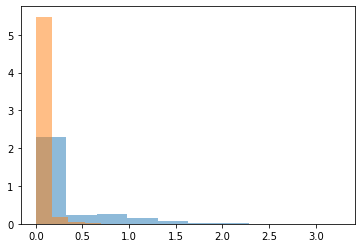

In [156]:
f = '/proj/human_development/wholebrain_200702/data/Allbrain.loom'

with loompy.connect(f, 'r') as ds:
    print(ds.layers.keys())
    print(ds.shape)
    
    plt.hist(np.log10(ds.layers['pooled'][:,0]+1), density=True, alpha=0.5)
    plt.hist(np.log10(ds.layers[''][:,0]+1), density=True, alpha=0.5)
    print(Counter(ds.layers[''][:,0]))
    print(Counter(ds.layers['pooled'][:,0]))
    print(np.sum(ds.layers['pooled'][:,0] >0))
    print(np.unique(ds.layers['pooled'][:,0]))

14:33:34 INFO     Sparsity before imputation: 0.9484368319724437
14:34:00 INFO     Sparsity after imputation: 0.7600799255538468


[0 1]
[0 1 2 3 4 5 7]


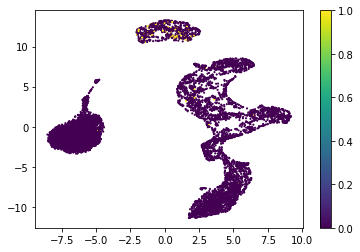

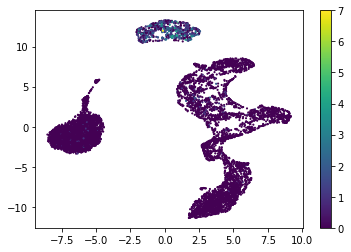

In [134]:
## Test poisson pooling
import logging
import warnings
from typing import List

import numpy as np
import scipy.sparse as sparse
from numba.core.errors import NumbaPendingDeprecationWarning, NumbaPerformanceWarning
from pynndescent import NNDescent
from scipy.sparse import SparseEfficiencyWarning

import loompy
from cytograph.decomposition import HPF, PCA
from cytograph.enrichment import FeatureSelectionByVariance
from cytograph.metrics import jensen_shannon_distance
from cytograph.preprocessing import Normalizer

f1 = '/proj/DEV_ATAC/PBMC_20200825/All/All_peaks.loom'
f2 = '/proj/DEV_ATAC/PBMC_20200825/All/All_peaks.agg.loom'

k = 10

with loompy.connect(f1) as ds:

#     nn = NNDescent(data=ds.ca.LSI, metric=(jensen_shannon_distance if factorization == "HPF" else "euclidean"))
    nn = NNDescent(data=ds.ca.LSI, metric="euclidean")
    indices, distances = nn.query(ds.ca.LSI, k=k)
    # Note: we convert distances to similarities here, to support Poisson smoothing below
    knn = sparse.csr_matrix(
        (np.ravel(distances), np.ravel(indices), np.arange(0, distances.shape[0] * distances.shape[1] + 1, distances.shape[1])), (ds.ca.LSI.shape[0], ds.ca.LSI.shape[0])
    )
    max_d = knn.data.max()
    knn.data = (max_d - knn.data) / max_d
    knn.setdiag(1)  # This causes a sparse efficiency warning, but it's not a slow step relative to everything else
    
    knn = knn.astype("bool")

    logging.debug(f"Poisson pooling")
    ds["pooled"] = 'int32'
    
    for (_, indexes, view) in ds.scan(axis=0, layers=[""], what=["layers"]):
        ds["pooled"][indexes.min(): indexes.max() + 1, :] = view[:, :] @ knn.T
    
    logging.info("Sparsity before imputation: {}".format(1 - np.sum(ds.map([np.count_nonzero], axis=1)[0]) / (ds.shape[0] * ds.shape[1])))
    logging.info("Sparsity after imputation: {}".format(1 - np.sum(ds.layer['pooled'].map([np.count_nonzero], axis=1)[0]) / (ds.shape[0] * ds.shape[1])))
    
    with loompy.connect(f2) as dsout:
        p = np.where(dsout.ra.markerPeaks)[0][0]

        plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=ds.layers[''][p,:], s=5,  marker='.')
        plt.colorbar()
        
        plt.figure()
        plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=ds.layers['pooled'][p,:], s=5,  marker='.')
        plt.colorbar()
        
        print(np.unique(ds.layers[''][p,:]))
        print(np.unique(ds.layers['pooled'][p,:]))
        
        

In [137]:
with loompy.connect(f1, 'r') as ds:
    X = ds.layer['pooled'][:,:].flatten()
    cnt = Counter(X)
    print(cnt)

Counter({0: 933679990, 1: 144160528, 2: 57920109, 3: 33418456, 4: 22509464, 5: 15567555, 6: 10273624, 7: 6145216, 8: 3150817, 9: 1262815, 10: 308544})


In [157]:
with loompy.connect(f1, 'r') as ds:
    if 'LSI' in ds.ca:
        print('True')

True


[0 1]
[0.         0.04761905 0.05       0.05263158 0.05555556 0.05882353
 0.0625     0.06666667 0.07142857 0.07692308 0.08333334 0.09090909
 0.0952381  0.1        0.10526316 0.11111111 0.11764706 0.125
 0.13333334 0.14285715 0.15       0.15384616 0.15789473 0.16666667
 0.1764706  0.18181819 0.1875     0.1904762  0.2        0.21052632
 0.21428572 0.22222222 0.23076923 0.23529412 0.23809524 0.25
 0.2631579  0.27272728 0.2857143  0.29411766 0.3        0.3125
 0.31578946 0.33333334 0.36363637 0.375      0.3846154  0.3888889
 0.4        0.41666666 0.42857143 0.45454547 0.5        1.        ]
105
182.51866


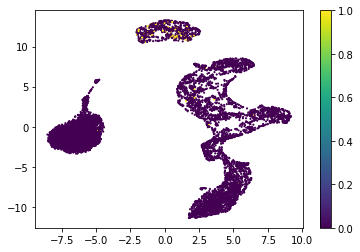

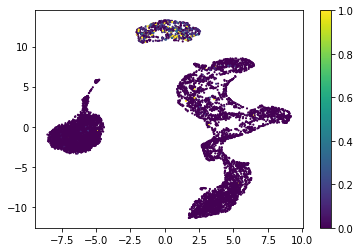

In [126]:
from cytograph.manifold import BalancedKNN

with loompy.connect(f1) as ds:
    
    ## Loading the network
    bnn = BalancedKNN(k=k, metric='euclidean', maxl=2 * k, sight_k=2 * k, n_jobs=-1)
    bnn.fit(ds.ca.LSI)

    logging.debug(f"Poisson pooling")
    ds["pooled"] = 'float32'
    
    for (_, selection, view) in ds.scan(axis=0):
        ds['pooled'][selection,:] = bnn.smooth_data(view[''][:,:], only_increase=True)
        
    with loompy.connect(f2) as dsout:
        p = np.where(dsout.ra.markerPeaks)[0][0]

        plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=ds.layers[''][p,:], s=5,  marker='.')
        plt.colorbar()
        
        plt.figure()
        plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=ds.layers['pooled'][p,:], s=5,  marker='.')
        plt.colorbar()
        
        print(np.unique(ds.layers[''][p,:]))
        print(np.unique(ds.layers['pooled'][p,:]))
        
        print(np.sum(ds.layers[''][p,:]))
        print(np.sum(ds.layers['pooled'][p,:]))

In [124]:
with loompy.connect(f1) as ds:
    with loompy.connect(f2) as dsout:
        p = np.where(dsout.ra.markerPeaks)[0][0]
        print(np.sum(ds.layers[''][p,:]))
        print(np.sum(ds.layers['pooled'][p,:]))

105
105


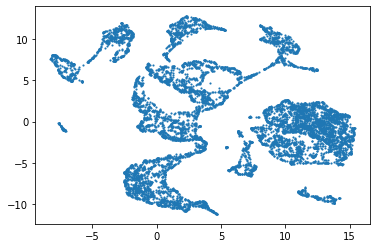

In [166]:
with loompy.connect(f1) as ds:
    plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], s=5,  marker='.')

[0 1]
[0 1 2 3 4 5 6 7]
275
1944


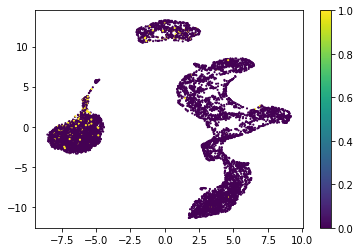

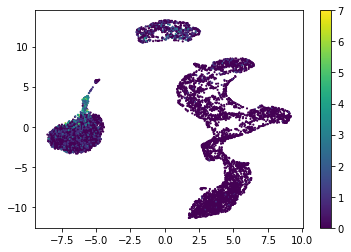

In [159]:
x = 0.2

with loompy.connect(f1) as ds:
    with loompy.connect(f2) as dsout:
        p = np.where(dsout.ra.markerPeaks)[0][1]

        plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=ds.layers[''][p,:], s=5,  marker='.')
        plt.colorbar()
        
        plt.figure()
        plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c=ds.layers['pooled'][p,:], s=5,  marker='.')
        plt.colorbar()
        
        print(np.unique(ds.layers[''][p,:]))
        print(np.unique(ds.layers['pooled'][p,:]))
        
        print(np.sum(ds.layers[''][p,:]))
        print(np.sum(ds.layers['pooled'][p,:] > x))

In [32]:
from pybedtools import BedTool

f = '/proj/DEV_ATAC/PBMC_20200825/All/All_peaks.agg.loom'
bed_file = '/proj/DEV_ATAC/misc/peaks.bed'

with loompy.connect(f) as ds:
    Valids = ds.layers['marker_peaks'][:,14]
    peaks = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x]), '.', '+') for x in np.where(Valids)[0]]).saveas(bed_file)

In [15]:
import cytograph.plotting as cgplot

with loompy.connect(f1) as ds:
    with loompy.connect(agg_file) as dsout:
        cgplot.markerheatmap(ds, dsout, os.path.join('/proj/DEV_ATAC/PBMC_20200825/All/exported', f"All_motifs_heatmap.pdf"), layer="")


/home/camiel/cytograph-dev/cytograph/plotting/heatmap.py:28: RuntimeWarning: invalid value encountered in log
  data = np.log(ds[layer][:len(self.genes), :] + 1)


AttributeError: '<class 'loompy.layer_manager.LayerManager'>' object has no attribute 'enrichment'

In [12]:
## Create spiked dataset with some known non-cancer cells

GA = '/proj/DEV_ATAC/Kriegstein_20200729/IDH1/IDH1_GA.loom'
GA2 = '/proj/DEV_ATAC/PBMC_20200825/All/All_GA.loom'

N_spiked = 1000

from collections import Counter
import random

with loompy.connect(GA, 'r') as ds:
    logging.info(f'Loading data')
    cnt = Counter(ds.ra.Gene)
    invalid = [k for k, v in cnt.items() if v > 1]
    valid = [x not in invalid for x in ds.ra.Gene]
    vals = ds['CPM'][np.where(valid)[0],:]
    genes = ds.ra.Gene[np.where(valid)[0]]
    
    ## reorder
    vals = vals[np.argsort(genes),:]
    sorted_genes = genes[np.argsort(genes)]
    
    logging.info(f'Adding rows and columns')
    export = np.hstack((np.zeros((np.sum(valid)+1,1)), np.vstack((np.zeros(ds.shape[1]), vals)))).astype(str)
    export[0,0] = 'GENE'
    export[0,1:] = ds.ca.CellID
    export[1:,0] = sorted_genes

with loompy.connect(GA2, 'r') as ds:
    
    logging.info(f'Loading data')
    cnt = Counter(ds.ra.Gene)
    invalid = [k for k, v in cnt.items() if v > 1]
    valid = [x not in invalid for x in ds.ra.Gene]
    
    selected = sorted(random.sample(range(ds.shape[1]), N_spiked))

    vals = ds['CPM'][np.where(valid)[0],:][:,selected]
    vals = vals/(1e-6*ds.ca.GA_colsum[selected])
    genes = ds.ra.Gene[np.where(valid)[0]]
    
    ## reorder
    vals = vals[np.argsort(genes),:]
    sorted_genes2 = genes[np.argsort(genes)]
    
    if not (sorted_genes2 == sorted_genes).all():
        logging.info('Gene order screwed up!')

    logging.info(f'Adding rows and columns')
    export = np.hstack((export, np.vstack((np.zeros(N_spiked), vals)).astype(str)))
    export[0,-N_spiked:] = [f'control:{x}' for x in range(N_spiked)]
        
    logging.info(f'Saving to file')
    np.savetxt('/fish/other_tmp/camiel_tmp/test_CONICS/spiked_CPM.txt', export, delimiter='\t', fmt='%s')

14:07:52 INFO     Loading data
14:08:18 INFO     Adding rows and columns
14:09:50 INFO     Loading data
14:10:11 INFO     Adding rows and columns
14:10:38 INFO     Saving to file


In [9]:
N_spiked = 1000
ds_shape = [20000, 9000]

import random
selected = sorted(random.sample(range(ds_shape[1]), N_spiked))
selected

[16,
 22,
 27,
 36,
 42,
 59,
 63,
 84,
 92,
 112,
 130,
 146,
 148,
 153,
 173,
 175,
 181,
 185,
 212,
 234,
 237,
 244,
 251,
 257,
 263,
 269,
 271,
 272,
 279,
 289,
 292,
 299,
 303,
 312,
 320,
 364,
 380,
 391,
 392,
 403,
 409,
 413,
 435,
 439,
 444,
 445,
 451,
 456,
 463,
 467,
 473,
 476,
 486,
 488,
 499,
 501,
 506,
 517,
 533,
 543,
 559,
 565,
 590,
 602,
 603,
 604,
 616,
 619,
 628,
 648,
 654,
 656,
 664,
 672,
 687,
 693,
 698,
 701,
 705,
 727,
 740,
 743,
 747,
 749,
 751,
 759,
 785,
 787,
 803,
 810,
 825,
 851,
 865,
 878,
 889,
 913,
 919,
 960,
 970,
 973,
 1000,
 1003,
 1008,
 1030,
 1033,
 1036,
 1039,
 1048,
 1061,
 1066,
 1074,
 1099,
 1101,
 1108,
 1115,
 1126,
 1135,
 1143,
 1147,
 1161,
 1173,
 1175,
 1180,
 1188,
 1191,
 1196,
 1205,
 1206,
 1208,
 1214,
 1238,
 1264,
 1268,
 1269,
 1288,
 1292,
 1299,
 1312,
 1314,
 1316,
 1319,
 1324,
 1335,
 1338,
 1339,
 1342,
 1363,
 1367,
 1412,
 1418,
 1424,
 1438,
 1446,
 1465,
 1466,
 1467,
 1490,
 1503,
 15

In [98]:
cnt = Counter(export[0,1:])

[print(k, v) for k,v in cnt.items() if v > 1]
Counter([x.split(':')[0] for x in export[0, 1:]])

[]

In [2]:
export = np.loadtxt('/fish/other_tmp/camiel_tmp/test_CONICS/IDH1_CPM.txt', dtype=str)

(array([2185., 1005.,  818.,  741.,  698.,  713.,  744.,  863.,  875.,
         923.,  974.,  944.,  980.,  869.,  796.,  758.,  670.,  632.,
         573.,  491.,  445.,  360.,  328.,  292.,  265.,  253.,  217.,
         171.,  165.,  117.]),
 array([0.        , 0.03324707, 0.06649415, 0.09974122, 0.13298829,
        0.16623537, 0.19948244, 0.23272951, 0.26597659, 0.29922366,
        0.33247073, 0.36571781, 0.39896488, 0.43221195, 0.46545903,
        0.4987061 , 0.53195317, 0.56520025, 0.59844732, 0.63169439,
        0.66494147, 0.69818854, 0.73143561, 0.76468269, 0.79792976,
        0.83117683, 0.86442391, 0.89767098, 0.93091805, 0.96416513,
        0.9974122 ]),
 <a list of 30 Patch objects>)

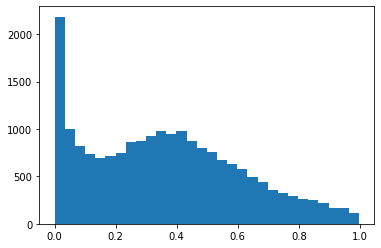

In [9]:
# vals = export[1:,1:].astype('float')

cov = np.sum(vals>0, axis = 1) / vals.shape[1]
plt.hist(cov, bins = 30)

"BIC 1 component"	"BIC 2 components"	"BIC difference"	"LRT adj. p-val"

[['"1p"' '32142.4370444573' '31369.4894422062' '772.947602251079' '0']
 ['"1q"' '32142.4370444573' '30074.8956594508' '2067.5413850065' '0']
 ['"2p"' '32142.4370444573' '31284.748341311' '857.688703146287' '0']
 ['"2q"' '32142.4370444573' '30994.529312753' '1147.90773170432' '0']
 ['"3p"' '32142.4370444573' '30474.4623110667' '1667.97473339056' '0']
 ['"3q"' '32142.4370444573' '31239.1459185238' '903.291125933538' '0']
 ['"4p"' '32142.4370444573' '31190.8468112862' '951.590233171148' '0']
 ['"4q"' '32142.4370444573' '31518.0848213414' '624.352223115875' '0']
 ['"5p"' '32142.4370444573' '31262.3877381189' '880.049306338424' '0']
 ['"5q"' '32142.4370444573' '30961.9949798245' '1180.44206463277' '0']
 ['"6p"' '32142.4370444573' '31593.5099789362' '548.927065521071' '0']
 ['"6q"' '32142.4370444573' '30842.5024565681' '1299.93458788918' '0']
 ['"7p"' '32142.4370444573' '31226.2421959238' '916.194848533523' '0']
 ['"7q"'

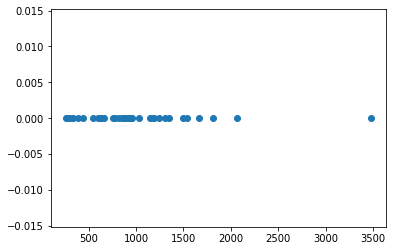

In [17]:
f ='/fish/other_tmp/camiel_tmp/test_CONICS/SUVA_CNVs_BIC_LR.txt'

stat = np.loadtxt(f, dtype=str, skiprows=1)

with open(f, "r") as file:
    header = file.readline()
    print(header)

plt.scatter(stat[:,-2].astype('float'), stat[:,-1].astype('float'))
print(stat)

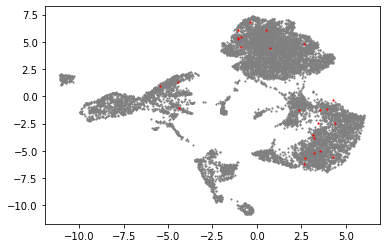

In [16]:
CNV_lab = {k.strip('"'): int(v) for k, v in np.loadtxt('/fish/other_tmp/camiel_tmp/test_CONICS/clusters.txt', dtype=str, skiprows=1)}
cnt = Counter([v for k,v in CNV_lab.items()])

GA = '/proj/DEV_ATAC/Kriegstein_20200729/IDH1/IDH1_GA.loom'
with loompy.connect(GA, 'r') as ds:
    
    for c, color in zip(np.unique(list(cnt.keys())), ['gray', 'red', 'blue']):
        v = [CNV_lab[x] == c for x in ds.ca.CellID]
        plt.scatter(ds.ca.UMAP[v,0], ds.ca.UMAP[v,1], c = color, s=5,  marker='.')

In [65]:
with loompy.connect(GA, 'r') as ds:
    print(ds.ca.keys())

['Age', 'All_fc_analysis_id', 'Analysis', 'Bplength', 'Cdnalibcomment', 'Cdnalibok', 'CellID', 'Cellconc', 'Chemistry', 'Clusterdensity', 'Clusterpf', 'Clusters', 'ClustersModularity', 'ClustersModularity_bin', 'ClustersSurprise', 'ClustersSurprise_bin', 'Clusters_bin', 'Comment', 'DNase_sensitive_region_fragments', 'Datecaptured', 'Dateseqlib', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'Editat', 'Editby', 'Finalconc', 'GA_colsum', 'HPF', 'HPF_theta', 'Id', 'Idxset', 'Inputmrna', 'LSI', 'Label', 'Method', 'Molarity', 'NBins', 'NPeaks', 'Name', 'Neuronprop', 'Ngperulcdna', 'Numpooledanimals', 'Outliers', 'OutliersModularity', 'OutliersModularity_bin', 'OutliersSurprise', 'OutliersSurprise_bin', 'PCA', 'Pcrcycles', 'Plugdate', 'Project', 'Read1specificseq', 'Roi', 'Sampleok', 'Seqcomment', 'Seqlibcomment', 'Seqlibok', 'Sex', 'Shearing', 'Shortname', 'Species', 'Strain', 'TSNE', 'TSNE_bin', 'TSS_fragments', 'Targetnumcells', 'Tissue', 'Totcells', 'Totreads', 'Transcriptome', 'UM

Counter({1: 10776, 2: 25, 3: 19})


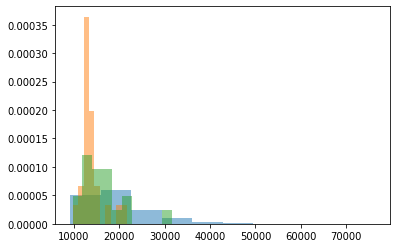

In [66]:
cnt = Counter([v for k,v in CNV_lab.items()])
print(cnt)

with loompy.connect(GA, 'r') as ds:

    for c in np.unique(list(cnt.keys())):
        v = [CNV_lab[x] == c for x in ds.ca.CellID]
        plt.hist(ds.ca.passed_filters[v], alpha=.5, density=True)

Counter({'SF11964': 5099, 'SF11612': 3738, 'SF11949': 1939})
Counter({'SF11612': 18, 'SF11949': 6, 'SF11964': 1})
Counter({'SF11612': 8, 'SF11949': 8, 'SF11964': 3})


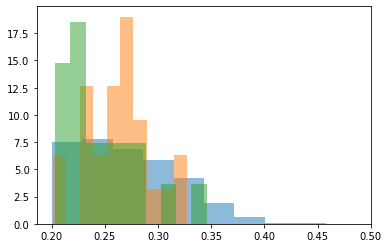

In [69]:
with loompy.connect(GA, 'r') as ds:
    frip = ds.ca.promoter_region_fragments/ds.ca.passed_filters
    
    for c in np.unique(list(cnt.keys())):
        v = [CNV_lab[x] == c for x in ds.ca.CellID]
        plt.hist(frip[v], alpha=.5, density=True)
        
        print(Counter(ds.ca.Shortname[v]))

In [56]:
np.unique(list(cnt.keys()))[0]

1

09:42:29 INFO     Plotting UMAP
09:42:34 INFO     Plotting TSNE
09:42:40 INFO     plotting attributes


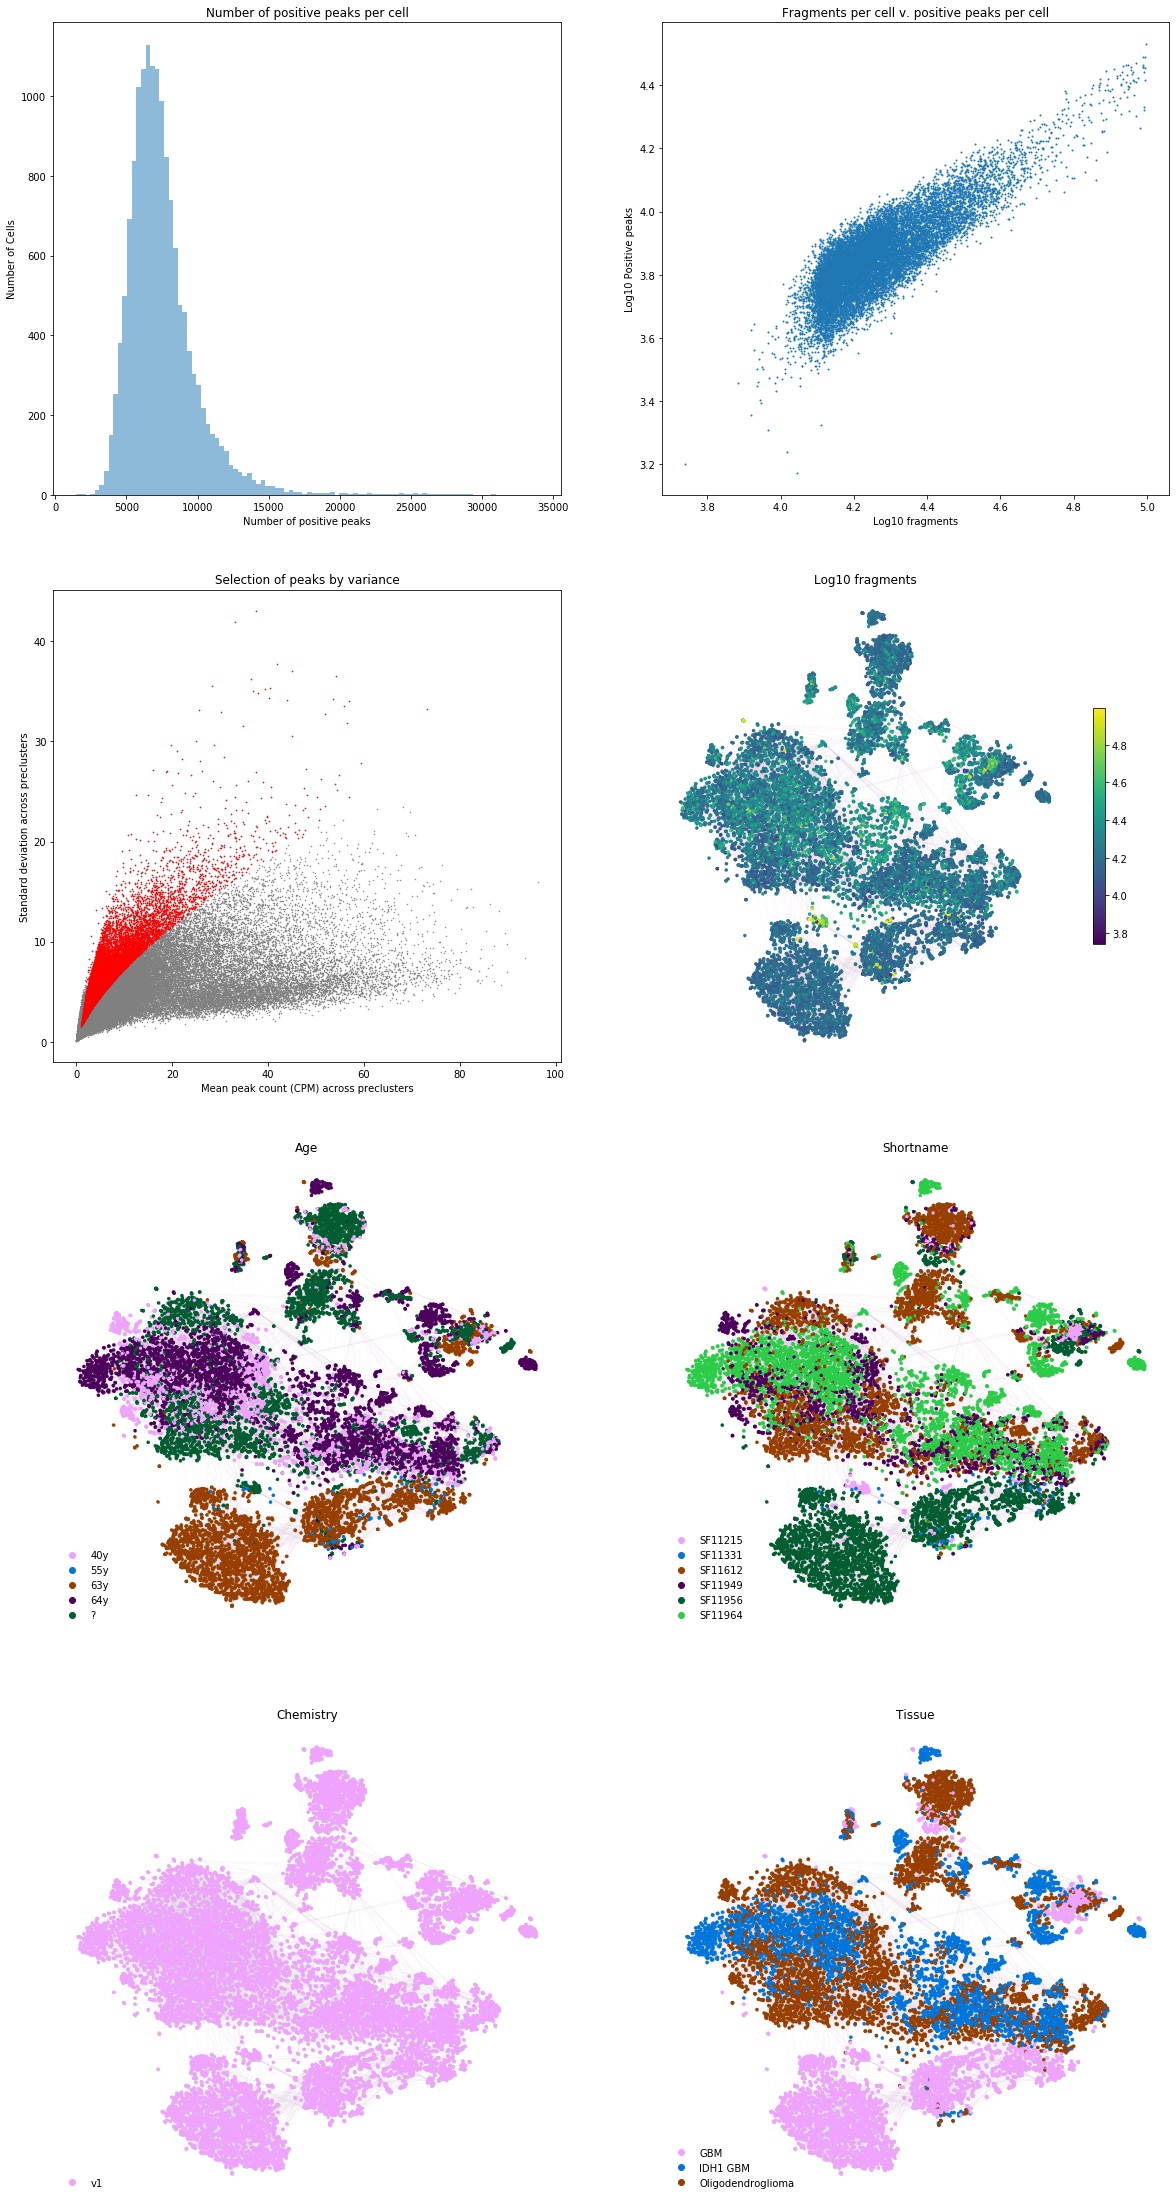

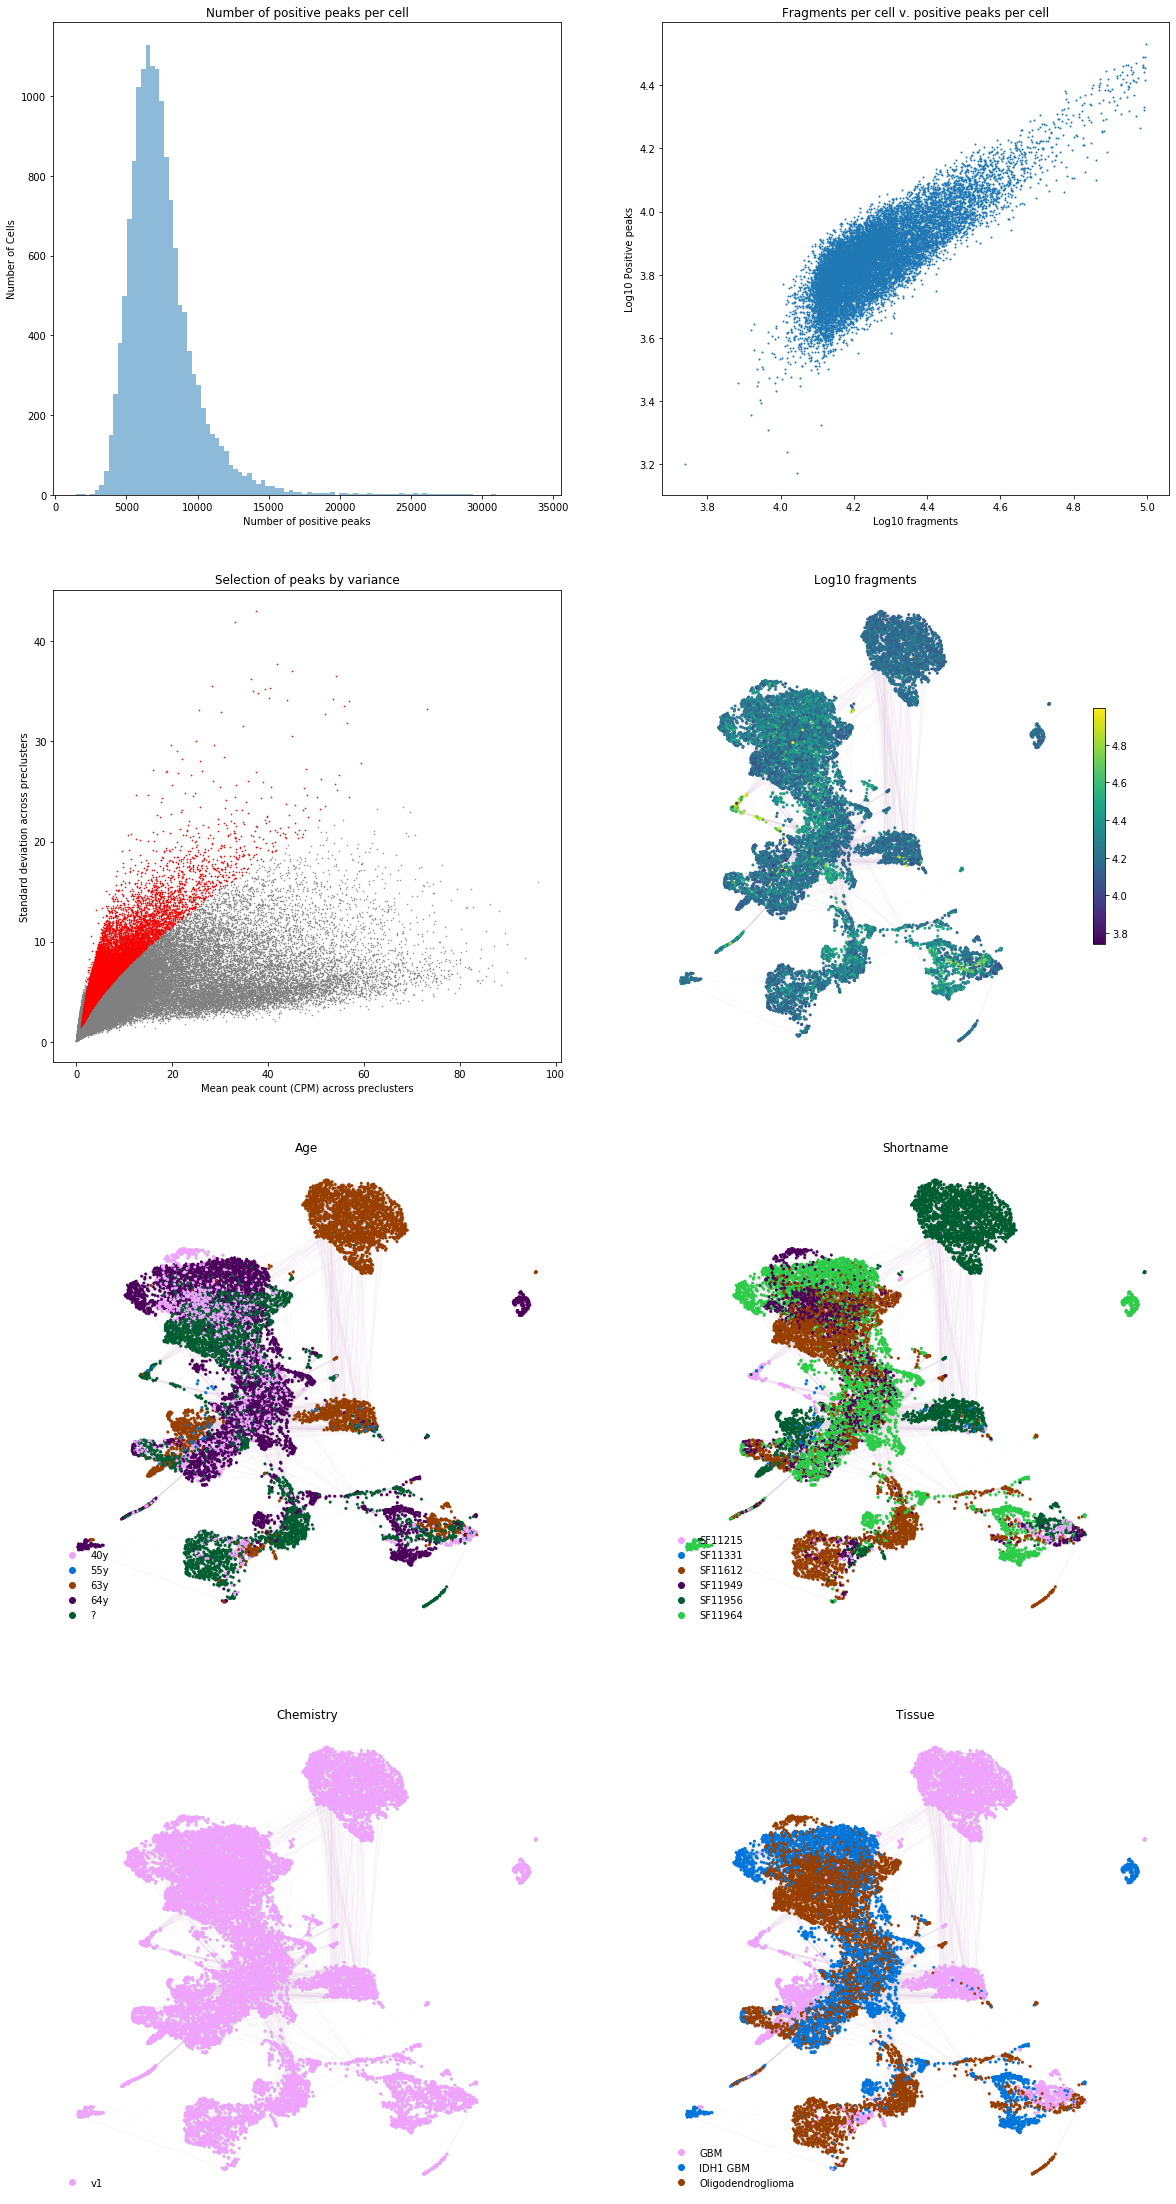

In [186]:
GA = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_peaks.loom'

from cytograph.plotting import manifold
from chromograph.plotting.QC_plot import QC_plot

outdir = '/proj/DEV_ATAC/Kriegstein_20200729/All/exported'

with loompy.connect(GA, 'r') as ds:
    name = ds.filename.split("/")[-1].split(".")[0].split("_")[0]
    
    ## Plot results on manifold
    logging.info("Plotting UMAP")
    manifold(ds, os.path.join(outdir, f"{name}_peaks_manifold_UMAP.png"), embedding = 'UMAP')
    logging.info("Plotting TSNE")
    manifold(ds, os.path.join(outdir, f"{name}_peaks_manifold_TSNE.png"), embedding = 'TSNE')
    logging.info("plotting attributes")
    QC_plot(ds, os.path.join(outdir, f"{name}_peaks_manifold_QC.png"), embedding = 'TSNE', attrs=['Age', 'Shortname', 'Chemistry', 'Tissue'])
    QC_plot(ds, os.path.join(outdir, f"{name}_peaks_manifold_UMAP_QC.png"), embedding = 'UMAP', attrs=['Age', 'Shortname', 'Chemistry', 'Tissue'])

In [131]:
tmp = '/data/proj/scATAC/samples/10XSF11612/10XSF11612_GA.loom'
from collections import Counter

with loompy.connect(tmp, 'r') as ds:
    cnt = Counter(ds.ra.Gene)
    totals = ds[''].map([np.sum], axis = 1)[0]
    invalid = [k for k, v in cnt.items() if v > 1]
    valid = [x not in invalid for x in ds.ra.Gene]
    vals = ds[''][np.where(valid)[0],:]
#     vals = vals/(1e-6*totals)
    vals = vals/(1e-6*ds.ca.passed_filters)

    export = np.zeros((np.sum(valid)+1, ds.shape[1]+1)).astype(str)
    export[0,0] = 'GENE'
    export[0,1:] = ds.ca.CellID
    export[1:,0] = ds.ra.Gene[np.where(valid)[0]]
    export[1:,1:] = vals
    np.savetxt('/fish/other_tmp/camiel_tmp/test_CONICS/SF11612.txt', export, delimiter='\t', fmt='%s')

[2. 2. 0. 2. 1. 0. 1. 2. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 4. 0. 2. 1. 0. 0. 2. 1. 1. 2. 0. 0. 1. 0. 1. 2. 0. 1. 1. 3. 1. 2. 0.
 1. 0. 1. 0. 1. 5. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 2. 0. 1. 0. 0. 1. 0.
 1. 0. 2. 0. 1. 1. 0. 1. 1. 2. 0. 2. 0. 0. 1. 0. 0. 2. 0. 0. 0. 2. 0. 0.
 0. 0. 0. 0.]


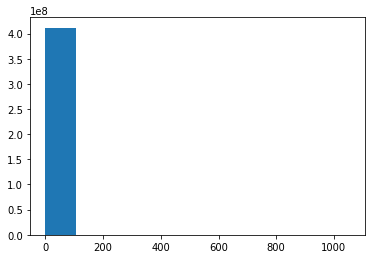

In [221]:
GA = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_GA.loom'

with loompy.connect(GA, 'r') as ds:
    vals = ds['raw'][:,:].flatten()
    
# from collections import Counter
# cnt = Counter(vals)
# print(cnt)

print(vals[:100])

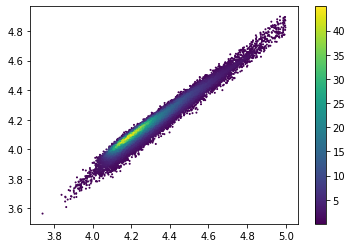

In [140]:
from scipy.stats import gaussian_kde

f_bins = '/proj/DEV_ATAC/Kriegstein_20200729/All/All.loom'
f_GA = '/proj/DEV_ATAC/Kriegstein_20200729/All/All_GA.loom'

with loompy.connect(f_bins, 'r') as ds:
    with loompy.connect(f_GA, 'r') as dsa:
#         mu = ds[''].map([np.sum], axis=1)[0]
#         plt.scatter(dsa.ca.GA_colsum, dsa.ca.passed_filters, s=1)

        xy = np.vstack([np.log10(dsa.ca.passed_filters+1), np.log10(dsa.ca.GA_colsum+1)])
        z = gaussian_kde(xy)(xy)

        ##Plot points
        plt.scatter(xy[0,:], xy[1,:], c=z, s=1)
        plt.colorbar()

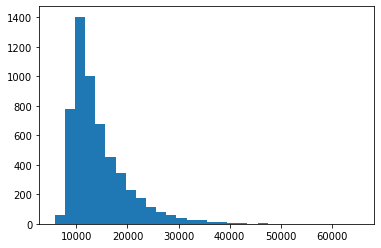

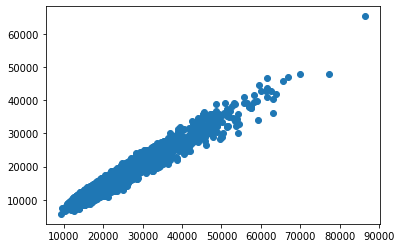

In [139]:
tmp = '/data/proj/scATAC/samples/10XSF11612/10XSF11612_GA.loom'
with loompy.connect(tmp, 'r') as ds:
    mu = ds[''].map([np.sum], axis=1)[0]
    plt.hist(mu, bins=30)
    
    plt.figure()
    plt.scatter(ds.ca.passed_filters, mu)

(154420, 20681)


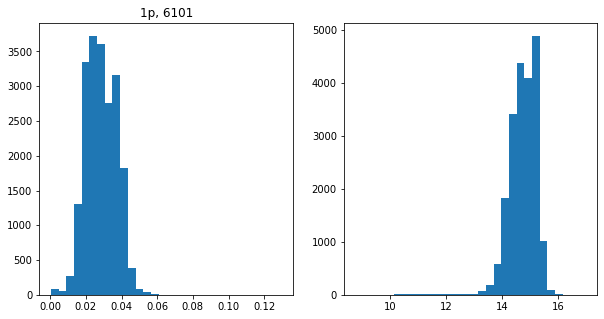

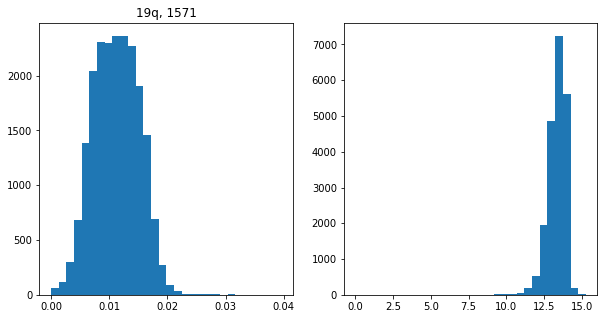

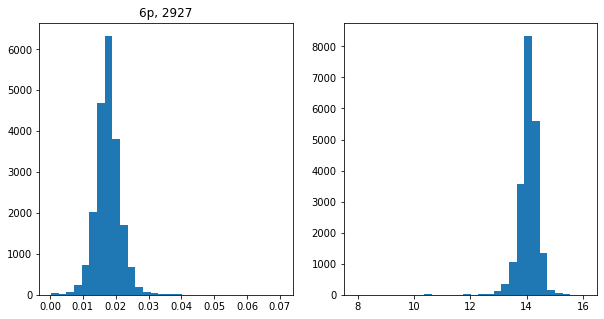

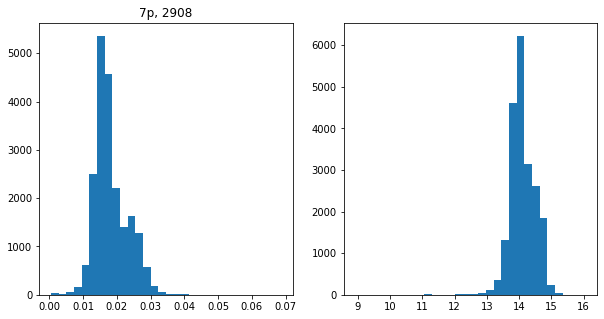

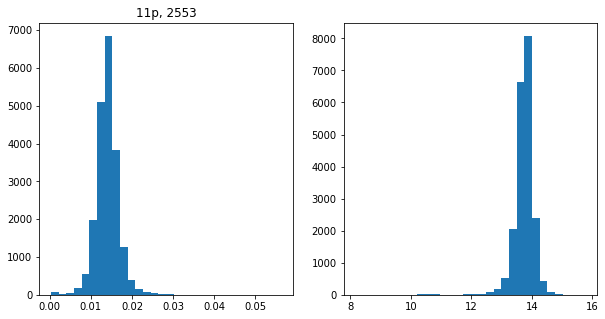

In [170]:
f_bins = '/proj/DEV_ATAC/Kriegstein_20200729/All/All.loom'

with loompy.connect(f_bins, 'r') as ds:
    print(ds.shape)
    mu = ds[''].map([np.sum], axis=1)[0]
    arms = np.loadtxt("/home/camiel/chromograph/chromograph/references/chromosome_arm_positions_grch38.txt", dtype=str, skiprows=1)
    cnt = Counter(ds.ra.chrom)
    
    for x in [0, 37, 10, 12, 20]:
        Valid = (ds.ra.chrom == f'chr{arms[x,1]}') & (ds.ra.start.astype(int) >=int(arms[x,2])) & (ds.ra.end.astype(int) <= int(arms[x,3]))
        bins = ds['20kb_bins'].sparse(rows=Valid)

        a = bins.sum(axis=0)
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].hist(np.asarray(a).flatten()/mu, bins = 30)
        ax[0].set_title(f'{arms[x,0]}, {sum(Valid)}')
    
        ax[1].hist(np.log2(np.asarray(a).flatten()/(1e-6*mu)+1), bins=30)

### Data Greenleaf

In [2]:
import scipy
import os
import pandas as pd
import loompy
import numpy as np
from pybedtools import BedTool

In [3]:
fdir = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Greenleaf_immune'
file_m = os.path.join(fdir, 'GSE129785_scATAC-Hematopoiesis-All.mtx')
file_b = os.path.join(fdir, 'GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt.gz')
file_p = os.path.join(fdir, 'GSE129785_scATAC-Hematopoiesis-All.peaks.txt.gz')

mat = scipy.io.mmread(file_m).astype('int8')

In [4]:
import pandas as pd
barcodes = pd.read_table(file_b)
peaks = pd.read_csv(file_p)

In [5]:
col_attrs = {k: np.array(barcodes[k]) for k in barcodes}
if 'row_attrs' in locals():
    del row_attrs
for x in peaks['Feature']:
    if 'row_attrs' not in locals():
        row_attrs = {}
        chrom, start, end = x.split('_')
        row_attrs['ID'] = [f'{chrom}:{start}-{end}']
        row_attrs['Chr'] = [chrom]
        row_attrs['Start'] = [start]
        row_attrs['End'] = [end]
    else:
        chrom, start, end = x.split('_')
        row_attrs['ID'].append(f'{chrom}:{start}-{end}')
        row_attrs['Chr'].append(chrom)
        row_attrs['Start'].append(start)
        row_attrs['End'].append(end)

In [6]:
filename = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/looms/Greenleaf_peaks.loom'

loompy.create(filename, mat, row_attrs, col_attrs)

In [7]:
with loompy.connect(filename) as ds:
    print(ds.ca.keys())

['Barcodes', 'Clusters', 'FRIP', 'Group', 'Group_Barcode', 'Internal_Name', 'UMAP1', 'UMAP2', 'depth']


In [8]:
from chromograph.peak_analysis.utils import *

out_file = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/looms/Greenleaf_peaks.agg.loom'

agg_spec = {
    "Group": "tally",
    "Clusters": "first",
    "FRIP": "mean",
    "depth": "mean"
}

with loompy.connect(filename) as ds:
    ds.ca.Clusters = np.array([int(x.strip('Cluster')) for x in ds.ca.Clusters])
    ds.aggregate(out_file, None, "Clusters", "sum", agg_spec)
    
    with loompy.connect(out_file) as dsout:

        logging.info('Calculate coverage metrics')
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

        ## Normalize peak counts by total fragments per cluster
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

        ## Call positive and negative peaks for every cluster
        dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout)


12:47:37 INFO     Calculate coverage metrics
12:47:46 INFO     Convert to CPMs
12:47:49 INFO     Binarize peak matrix
100%|██████████| 31/31 [00:27<00:00,  1.12it/s]


12:48:19 INFO     Shape (571400, 31)


PermissionError: [Errno 13] Permission denied: '/home/camiel/anaconda3/envs/DNA_tools/bin/liftOver'

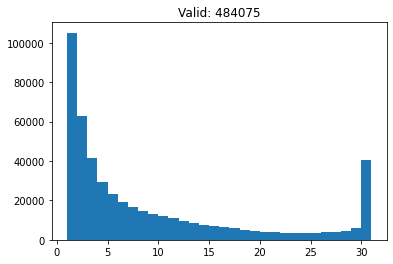

In [9]:
threshold = 1

bed_file = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/active_elements/Greenleaf.hg19.bed'
lifted_file = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/active_elements/Greenleaf.hg38.bed'
unlifted = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/active_elements/unlifted.bed'
with loompy.connect(out_file) as dsagg:
    logging.info(f'Shape {dsagg.shape}')
    Valids = []
    binary = dsagg['CPM'][:,:] > threshold
    ON = np.sum(binary[:,:], axis=1)
    Valids = ON > 0
    plt.figure()
    plt.title(f'Valid: {np.sum(Valids)}')
    plt.hist(ON[Valids], bins= 30)
    
with loompy.connect(out_file) as ds:
    enh = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in np.where(Valids)[0]]).saveas(bed_file)
    
subprocess.call(['/home/camiel/anaconda3/envs/DNA_tools/bin/liftOver', bed_file, '/datb/sl/camiel/scATAC/ref/hg19ToHg38.over.chain.gz', lifted_file, unlifted])
subprocess.call(['rm', unlifted])

### Corces data

In [11]:
fdir = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Corces_adult_brain/summarized'
file_m = os.path.join(fdir, 'GSE147672_200324_Brain_scATAC_SummarizedExperiment_forGEO.mtx')
file_b = os.path.join(fdir, 'GSE147672_200324_Brain_scATAC_SummarizedExperiment_forGEO.barcodes.tsv.gz')
file_p = os.path.join(fdir, 'GSE147672_200324_Brain_scATAC_SummarizedExperiment_forGEO.peaks.tsv.gz')

mat = scipy.io.mmread(file_m).astype('int8')

In [12]:
import pandas as pd
barcodes = pd.read_table(file_b)
peaks = pd.read_csv(file_p, '\t')

In [13]:
col_attrs = {k: np.array(barcodes[k]) for k in barcodes}
if 'row_attrs' in locals():
    del row_attrs
    
for x in range(len(peaks)):
    if 'row_attrs' not in locals():
        row_attrs = {}
        chrom, start, end = peaks['seqnames'][x], peaks['start'][x], peaks['end'][x]
        row_attrs['ID'] = [f'{chrom}:{start}-{end}']
        row_attrs['Chr'] = [chrom]
        row_attrs['Start'] = [start]
        row_attrs['End'] = [end]
    else:
        chrom, start, end = peaks['seqnames'][x], peaks['start'][x], peaks['end'][x]
        row_attrs['ID'].append(f'{chrom}:{start}-{end}')
        row_attrs['Chr'].append(chrom)
        row_attrs['Start'].append(start)
        row_attrs['End'].append(end)

In [14]:
filename = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/looms/Corces_peaks.loom'

loompy.create(filename, mat, row_attrs, col_attrs)

In [17]:
with loompy.connect(filename) as ds:
    print(ds.ca.keys())
    print(np.unique(ds.ca.Group))

['FRIP', 'Group', 'binarizedCountSums', 'countSums', 'fragmentsPerCell', 'readsInPeaks', 'totalReads', 'tssEnrichment']
['scATAC_CTRL_CAUD_06_0615' 'scATAC_CTRL_CAUD_09_1589'
 'scATAC_CTRL_CAUD_14_1018' 'scATAC_CTRL_HIPP_11_0393'
 'scATAC_CTRL_HIPP_14_0586' 'scATAC_CTRL_MDFG_09_35'
 'scATAC_CTRL_PARL_09_1589' 'scATAC_CTRL_SMTG_09_1589'
 'scATAC_CTRL_SUNI_03_39' 'scATAC_CTRL_SUNI_04_38']


In [1]:
import numpy as np
import pandas as pd
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import urllib.request
import pybedtools
import warnings
import logging
from tqdm import tqdm
from numba.core.errors import NumbaPerformanceWarning
import multiprocessing as mp
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

from cytograph.decomposition import HPF
from scipy.stats import poisson
from cytograph.manifold import BalancedKNN
from cytograph.metrics import jensen_shannon_distance
from cytograph.embedding import art_of_tsne
from cytograph.clustering import PolishedLouvain, PolishedSurprise
from cytograph.plotting import manifold

# sys.path.append('/home/camiel/chromograph/')
from chromograph.plotting.QC_plot import QC_plot
from chromograph.pipeline import config
from chromograph.pipeline.utils import *
from chromograph.pipeline.TF_IDF import TF_IDF
from chromograph.pipeline.PCA import PCA
from chromograph.peak_analysis.feature_selection_by_variance import FeatureSelectionByVariance

from pynndescent import NNDescent
from umap import UMAP
from joblib import parallel_backend
import sklearn.metrics
from scipy.spatial import distance
from harmony import harmonize
import community
import networkx as nx
from scipy import sparse
from typing import *

from pybedtools import BedTool

config = config.load_config()

In [2]:
def trim_by_conservation(enhancers: BedTool, s:int=300, max_plots = 0):
    trimmed = []
    plot = 0
    
    for enhancer in enhancers:
        enhancer_bed = f'{enhancer[3]}.bed'
        out_tab = f'{enhancer[3]}.tab'
        bases = BedTool([(enhancer[0], x, x+1, x) for x in range(int(enhancer[1])-1, int(enhancer[2]))]).saveas(enhancer_bed)
        subprocess.call(['/home/camiel/anaconda3/envs/chromo/bin/bigWigAverageOverBed', '/datb/sl/camiel/scATAC/ref/hg38.phastCons100way.bw', enhancer_bed, out_tab])
        tab = np.loadtxt(out_tab, dtype=str, delimiter='\t')
        con = tab[:,-1].astype(float)
        
        n_windows = len(con) - s
        
        if n_windows >= 1:
            score = [np.sum(con[x:x+s])for x in range(n_windows)]
            sel = np.where(score == np.max(score))[0][0]
            
            if plot < max_plots:
                # plot figure
                fig, ax = plt.subplots(2,1)
                ax[0].plot(con)
                ax[0].axvline(sel, c='red')
                ax[0].axvline(sel+s, c='red')
                ax[1].plot(np.linspace(np.round(s/2), n_windows+np.round(s/2), n_windows), score)
                ax[1].set_xlim(0,len(con))
                plot += 1
            
            ch, st, en = enhancer[0], int(enhancer[1])+sel, int(enhancer[1])+sel+s
            trimmed.append([ch, st, en, f'{ch}:{st}-{en}'])
        else:
            trimmed.append([enhancer[x] for x in range(4)])

        subprocess.call(['rm', enhancer_bed, out_tab])
        
    return BedTool([[x[0], str(x[1]),str(x[2]), x[3]] for x in trimmed])

In [3]:
import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

In [4]:
## Cluster the Corces data because cluster labels not provided
outdir = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/Corces_adult_brain/summarized'
name = 'Corces'
filename = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/looms/Corces_peaks.loom'
out_file = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/looms/Corces_peaks.agg.loom'


In [17]:
OPC = [16]
OLIGO = [3, 4, 19]
ASTRO = [9, 15,17]
MIC = [8, 10, 20, 21]
# NEUR = [0, 1, 11, 16]
NEUR = [0, 1, 2, 11, 12, 16]

17:40:25 INFO     Shape (444747, 22)


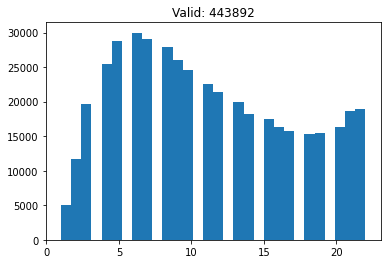

In [6]:
# threshold = 1

# bed_file = '/datb/sl/camiel/tumor/Healthy_tissues_scATAC/active_elements/Corces.hg38.bed'
# with loompy.connect(out_file) as dsagg:
#     logging.info(f'Shape {dsagg.shape}')
#     Valids = []
#     binary = dsagg['CPM'][:,:] > threshold
#     ON = np.sum(binary[:,:], axis=1)
#     Valids = ON > 0
#     plt.figure()
#     plt.title(f'Valid: {np.sum(Valids)}')
#     plt.hist(ON[Valids], bins= 30)
    
# with loompy.connect(out_file) as ds:
#     enh = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in np.where(Valids)[0]]).saveas(bed_file)

In [7]:
def isolate_enhancers(ds, reference):
    '''
    Remove all elements that do not overlap an annotated enhancer form the GENCODE dataset
    '''
    peak_list = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in range(len(ds.ra['Chr']))]).saveas()
    enhancers = BedTool(reference)
    peak_list = peak_list.intersect(enhancers, wa=True)
    enh_peaks = [x[3] for x in peak_list]
    Valid = [x in enh_peaks for x in ds.ra.ID]
    
    return np.array(Valid)

Calc q
Select valid
['chr11:116113961-116114461' 'chr15:88954775-88955275'
 'chr8:141317918-141318418']


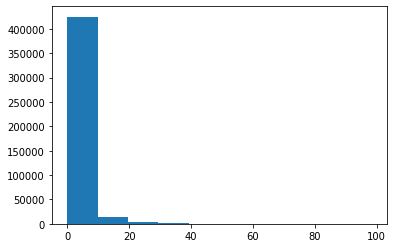

In [13]:
c = 15
N = 3

with loompy.connect(out_file) as dsagg:
    if 'selection' not in locals():
        print(f'Mark valid peaks')
        selection = isolate_enhancers(dsagg, os.path.join(config.paths.ref, 'regions', f'enhancer.bed'))
        selection = (selection) & (dsagg.ra.Chr != 'chrY') ## Remove the Y chromosome

    print(f'Calc q')
    X = dsagg.layers['enrichment'][:,c][selection]
    q = np.quantile(X, 1-(N/X.shape[0]))
    print(f'Select valid')
    e = np.where(dsagg.layers['enrichment'][:,c] > q)[0]
    x = list(set(e) & set(np.where(selection)[0]))
    astrocyte_enhancers = x
    print(dsagg.ra.ID[astrocyte_enhancers])
    
    plt.hist(dsagg.layers['enrichment'][:,c])

In [18]:
import fisher
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests

sig_thres = 0.05
mtc_method = 'fdr_bh'

with loompy.connect(out_file) as ds:
    X = np.sum(ds.layer[''][:,NEUR], axis=1)
    CPMs = div0(X, (np.sum(X) * 1e-6))
    Total = np.sum(ds.ca.NCells)
    n_cells = np.sum(ds.ca.NCells[NEUR])

    logging.info(f'Total cells: {Total}, Neurons: {n_cells}')
    
    logging.info(f'Performing Fisher exact tests')

    c = np.zeros((ds.shape[0],4))
    c[:,0] = np.array(X).astype('int').flatten()
    c[:,1] = ds.ra.NCells - c[:,0]
    c[:,2] = n_cells - c[:,0]
    c[:,3] = Total - n_cells - c[:,1]
    c = c.astype(np.uint)

    _, p, _ = fisher.pvalue_npy(c[:, 0], c[:, 1], c[:, 2], c[:, 3])
    odds = div0(c[:, 0] * c[:, 3], c[:, 1] * c[:, 2])

    logging.info(f'multiple test correction')
    _ , q, _, _ =  multipletests(p, sig_thres, method=mtc_method)

    enrichment = odds.reshape((ds.shape[0],1))
    q_values = np.array(q).reshape((ds.shape[0],1))

18:01:50 INFO     Total cells: 70631, Neurons: 34010
18:01:50 INFO     Performing Fisher exact tests
18:06:27 INFO     multiple test correction


Calc q
Select valid
['chr2:98375125-98375625' 'chr2:113651893-113652393'
 'chr2:237149330-237149830']


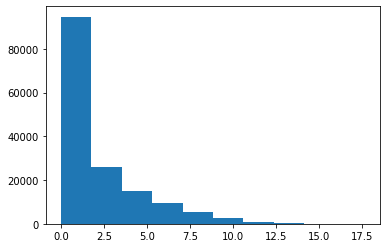

In [19]:
N = 3

with loompy.connect(out_file) as dsagg:
    if 'selection' not in locals():
        print(f'Mark valid peaks')
        selection = isolate_enhancers(dsagg, os.path.join(config.paths.ref, 'regions', f'enhancer.bed'))
        selection = (selection) & (dsagg.ra.Chr != 'chrY') ## Remove the Y chromosome

    print(f'Calc q')
    X = enrichment[selection]
    q = np.quantile(X, 1-(N/X.shape[0]))
    print(f'Select valid')
    e = np.where(enrichment > q)[0]
    x = list(set(e) & set(np.where(selection)[0]))
    neuron_enhancers = x
    print(dsagg.ra.ID[neuron_enhancers])
    
    plt.hist(X)

In [21]:
neuron_enhancers

[55785, 58521, 75895]

18:11:30 INFO     Trimmed enhancers astrocyte
18:11:35 INFO     Trimmed enhancers neuron


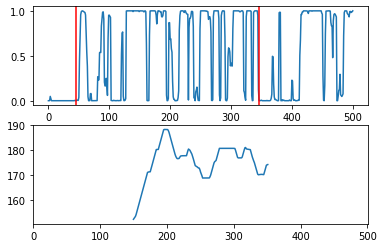

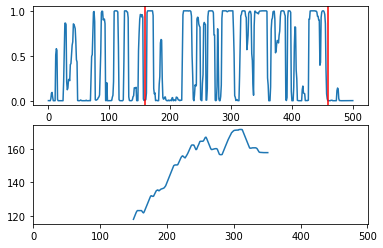

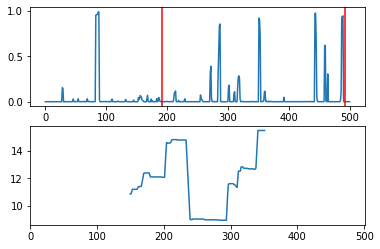

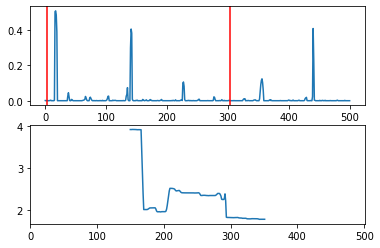

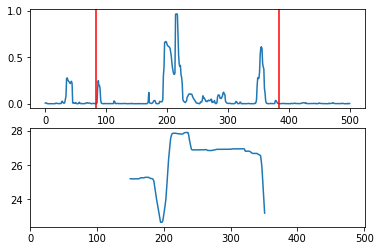

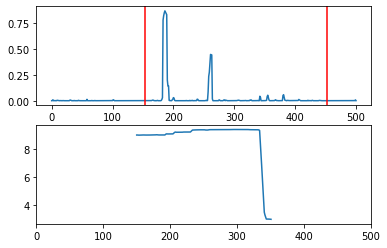

In [22]:
import subprocess

date = '20210323'
fasta = '/data/ref/cellranger-atac/refdata-cellranger-atac-GRCh38-1.2.0/fasta/genome.fa'
    
## Extract the most conserved region from peaks larger than 300 bp
with loompy.connect(out_file, 'r') as dsagg:
    for name, Selected_enhancers in zip(['astrocyte', 'neuron'],[astrocyte_enhancers, neuron_enhancers]):
        enhancers = BedTool([(dsagg.ra.Chr[x], str(dsagg.ra.Start[x]), str(dsagg.ra.End[x]), dsagg.ra.ID[x]) for x in Selected_enhancers])
        trimmed_enhancers = trim_by_conservation(enhancers, max_plots=6).saveas(f'/datb/sl/camiel/tumor/outputs/{name}_enhancers_{date}.bed')
        plt.savefig('/home/camiel/misc/enhancer_trimming.png')
        
        ## Get fasta files
        trimmed_enhcancers = trimmed_enhancers.sequence(fi=fasta)

        sq = open(trimmed_enhancers.seqfn).read().split('\n')
        sq = list(filter(None, sq))

        ## Save table to txt file
        table = np.array(sq).reshape(int(len(sq)/2),2)
        np.savetxt(f'/datb/sl/camiel/tumor/outputs/{name}_enhancers_{date}.txt', table, fmt='%s', delimiter='\t')
        logging.info(f'Trimmed enhancers {name}')